# Causal analysis pipeline — Endangered species in Asia

**Notebook purpose:** Complete pipeline (data ingestion → preprocessing → causal analysis → robustness) for endangered species in Asia with natural disasters as treatment.

**Geographic scope:** Asia bounding box [60°E, -10°S] to [150°E, 55°N]

**Temporal scope:** 2000–2024 (annual aggregation)

**Spatial resolution:** 0.1° grid (~11 km at equator)

**Disaster types:** Wildfires, floods, cyclones/typhoons, earthquakes

**Species:** IUCN threatened (CR, EN, VU) Aves, Mammalia, Reptilia, Amphibia with ≥50 GBIF occurrences

**Estimators:** DiD (TWFE), Sun-Abraham (staggered), Synthetic Control, Bayesian hierarchical

**Outputs:** Event-study plots, coefficient tables, maps, species summaries, robustness checks, processed panels

**Structure:**
1. Setup & dependencies
2. Configuration
3. Data ingestion: GBIF, EM-DAT, IUCN, hazard footprints
4. Preprocessing & grid alignment
5. Treatment construction
6. Outcome construction
7. Causal estimation (DiD, SCM, Bayesian)
8. Robustness & falsification
9. Visualization & reporting

In [57]:
# 2. Configuration — project parameters
from pathlib import Path
import datetime
import json
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt

load_dotenv()

CONFIG = {
    'study_name': 'endangered_asia_disaster_analysis',
    'data_dir': Path('data'),  # relative to notebook location
    'results_dir': Path('results'),
    'notebook_generated_on': datetime.datetime.utcnow().isoformat() + 'Z',
    
    # Spatial parameters
    'grid_resolution_deg': 1.0,  # Changed from 0.5 to 1.0 to reduce panel size (75% reduction)
    'region_bbox': [60.0, -10.0, 150.0, 55.0],  # [min_lon, min_lat, max_lon, max_lat]
    'use_range_filtering': True,  # Filter panel to only include grid cells within species' IUCN ranges
    
    # Temporal parameters
    'time_unit': 'year',
    'time_range': (2000, 2024),
    
    # Species selection
    'taxa': ['Aves', 'Mammalia', 'Reptilia', 'Amphibia'],
    'target_status': ['CR', 'EN', 'VU'],
    'min_occurrences': 50,  # minimum GBIF records per species
    
    # Disaster types
    'disaster_types': ['wildfire', 'flood', 'cyclone', 'earthquake'],
    
    # API credentials (fill these in)
    'gbif_user': None,  # GBIF username
    'gbif_password': None,  # GBIF password
    'gbif_email': None,
    'iucn_token': None,  # IUCN API token (if using API)
    
    # Analysis parameters
    'event_window': (-3, 5),  # years before/after for event study
    'clustering_var': 'grid_id',  # for standard errors
    'did_estimator': 'twfe',  # 'twfe', 'sun_abraham', or 'both'
    
    # Double ML parameters
    'ml_model': 'random_forest',  # Machine learning model for Double ML
    'n_folds': 5,  # Number of folds for cross-fitting
    
    # Output formats
    'save_intermediate': True,
    'figure_format': 'png',
    'figure_dpi': 300,
}

CONFIG['gbif_user'] = os.getenv('GBIF_USER')
CONFIG['gbif_password'] = os.getenv('GBIF_PASSWORD')
CONFIG['gbif_email'] = os.getenv('GBIF_EMAIL')
CONFIG['iucn_token'] = os.getenv('IUCN_TOKEN')

# Create directories
for dir_path in [CONFIG['data_dir'], CONFIG['results_dir']]:
    dir_path.mkdir(parents=True, exist_ok=True)
    (dir_path / 'raw').mkdir(exist_ok=True)
    (dir_path / 'processed').mkdir(exist_ok=True)

# Save config
with open(CONFIG['results_dir'] / 'config.json', 'w') as f:
    json.dump({k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()}, f, indent=2)

print(f"Configuration set for {CONFIG['study_name']}")
print(f"Study region: {CONFIG['region_bbox']}")
print(f"Time range: {CONFIG['time_range']}")
print(f"Grid resolution: {CONFIG['grid_resolution_deg']}°")

Configuration set for endangered_asia_disaster_analysis
Study region: [60.0, -10.0, 150.0, 55.0]
Time range: (2000, 2024)
Grid resolution: 1.0°


## 3. Data Sources Overview

**EM-DAT (CRED):** Global disaster records - requires registration at https://www.emdat.be/
- Download disasters for Asia, 2000-2024
- Filter by disaster types: wildfire, flood, storm, earthquake
- Save as `data/raw/emdat_asia_2000_2024.csv`

**GBIF:** Species occurrence data via API
- Implemented below with bulk download workflow
- Requires GBIF account (free): https://www.gbif.org/

**IUCN Red List:** Species range maps
- Download from https://www.iucnredlist.org/resources/spatial-data-download
- Requires acceptance of terms
- Save shapefiles to `data/raw/iucn/`

**Hazard-specific footprints:**
- MODIS/VIIRS burned area: https://modis-fire.umd.edu/
- Copernicus EMS flood footprints: https://emergency.copernicus.eu/
- USGS earthquake data: https://earthquake.usgs.gov/
- NASA GPM IMERG precipitation: https://gpm.nasa.gov/

**MODIS MCD12 land cover:** Annual global land cover at 500m
- Download from https://lpdaac.usgs.gov/products/mcd12q1v006/

In [2]:
# 4a. GBIF species list acquisition - get threatened species in Asia
import requests
import pandas as pd
from pygbif import species as gbif_species
from pygbif import occurrences as gbif_occ
import time

def get_iucn_threatened_species_asia(taxa_list, status_list, bbox, iucn_token=None):
    """
    Query IUCN Red List API for threatened species in Asia.
    If no API token, or if the API returns no results, returns a curated list of example species.

    For production: Get API token from https://apiv3.iucnredlist.org/api/v3/token
    """
    # If a processed target species file already exists, load it (preferred)
    target_path = CONFIG['data_dir'] / 'processed' / 'target_species.csv'
    if target_path.exists():
        print("Target species file already exists. Loading from file.")
        try:
            return pd.read_csv(target_path)
        except Exception as e:
            print(f"Warning: could not read existing target species file: {e}")

    species_list = []

    # Helper: curated fallback list
    curated_species = [
        # Aves (Birds)
        {'taxon': 'Aves', 'scientificName': 'Lophura edwardsi', 'status': 'CR'},
        {'taxon': 'Aves', 'scientificName': 'Arborophila davidi', 'status': 'EN'},
        {'taxon': 'Aves', 'scientificName': 'Turdoides striata', 'status': 'VU'},
        {'taxon': 'Aves', 'scientificName': 'Carpococcyx renauldi', 'status': 'EN'},

        # Mammalia (Mammals)
        {'taxon': 'Mammalia', 'scientificName': 'Panthera tigris', 'status': 'EN'},
        {'taxon': 'Mammalia', 'scientificName': 'Elephas maximus', 'status': 'EN'},
        {'taxon': 'Mammalia', 'scientificName': 'Rhinoceros sondaicus', 'status': 'CR'},
        {'taxon': 'Mammalia', 'scientificName': 'Pongo abelii', 'status': 'CR'},

        # Reptilia (Reptiles)
        {'taxon': 'Reptilia', 'scientificName': 'Crocodylus siamensis', 'status': 'CR'},
        {'taxon': 'Reptilia', 'scientificName': 'Chelonia mydas', 'status': 'EN'},
        {'taxon': 'Reptilia', 'scientificName': 'Cuora trifasciata', 'status': 'CR'},

        # Amphibia (Amphibians)
        {'taxon': 'Amphibia', 'scientificName': 'Ansonia latidisca', 'status': 'EN'},
        {'taxon': 'Amphibia', 'scientificName': 'Rhacophorus catamitus', 'status': 'VU'},
    ]

    if iucn_token.lower()!= 'none':
        print("IUCN token provided — attempting API lookup. If this returns no species, a curated fallback will be used.")
        base_url = "https://apiv3.iucnredlist.org/api/v3"
        headers = {'token': iucn_token}

        try:
            for taxon in taxa_list:
                for status in status_list:
                    try:
                        url = f"{base_url}/species/category/{status}"
                        response = requests.get(url, headers=headers, timeout=30)
                        if response.status_code == 200:
                            data = response.json()
                            for sp in data.get('result', []):
                                # Some IUCN responses use different keys; be defensive
                                class_name = sp.get('class_name') or sp.get('class') or sp.get('taxon_class') or ''
                                sci_name = sp.get('scientific_name') or sp.get('scientificName') or sp.get('scientificName')
                                taxonid = sp.get('taxonid') or sp.get('taxonID')
                                if class_name and class_name.lower() == taxon.lower():
                                    species_list.append({
                                        'taxon': taxon,
                                        'scientificName': sci_name,
                                        'status': status,
                                        'taxonid': taxonid
                                    })
                        else:
                            print(f"IUCN API returned status {response.status_code} for {taxon}/{status}")
                        time.sleep(0.5)
                    except Exception as e:
                        print(f"Error fetching {taxon} - {status}: {e}")
        except Exception as e:
            print(f"IUCN API lookup failed: {e}")

        if not species_list:
            print("IUCN API returned no species — falling back to curated example list.")
            species_list = curated_species
    else:
        print("No IUCN token provided. Using curated example species list.")
        species_list = curated_species

    return pd.DataFrame(species_list)

# Get species list
species_df = get_iucn_threatened_species_asia(
    CONFIG['taxa'], 
    CONFIG['target_status'],
    CONFIG['region_bbox'],
    iucn_token=CONFIG['iucn_token']
)

print(f"\nSpecies to analyze: {len(species_df)}")
# Avoid failing prints if dataframe is empty
if len(species_df) > 0:
    print(f"Taxonomic groups: {species_df['taxon'].value_counts().to_dict()}")
    print(f"Conservation status: {species_df['status'].value_counts().to_dict()}")
else:
    print("Warning: species list is empty — check IUCN token or processed target file")

# Save species list
try:
    species_df.to_csv(CONFIG['data_dir'] / 'processed' / 'target_species.csv', index=False)
    print(f"\nSaved species list to {CONFIG['data_dir'] / 'processed' / 'target_species.csv'}")
except Exception as e:
    print(f"Could not save species list: {e}")

species_df.head(10)

Target species file already exists. Loading from file.

Species to analyze: 13
Taxonomic groups: {'Aves': 4, 'Mammalia': 4, 'Reptilia': 3, 'Amphibia': 2}
Conservation status: {'EN': 6, 'CR': 5, 'VU': 2}

Saved species list to data\processed\target_species.csv


,taxon,scientificName,status
0,Aves,Lophura edwardsi,CR
1,Aves,Arborophila davidi,EN
2,Aves,Turdoides striata,VU
3,Aves,Carpococcyx renauldi,EN
4,Mammalia,Panthera tigris,EN
5,Mammalia,Elephas maximus,EN
6,Mammalia,Rhinoceros sondaicus,CR
7,Mammalia,Pongo abelii,CR
8,Reptilia,Crocodylus siamensis,CR
9,Reptilia,Chelonia mydas,EN


In [15]:
# 4b. GBIF bulk occurrence download workflow
from pygbif import occurrences as occ
import time
import zipfile
import os

def request_gbif_download(species_list, year_min, year_max, bbox, user, pwd, email):
    """
    Request bulk occurrence download from GBIF.
    Returns download key for later retrieval.
    """
    if not all([user, pwd, email]):
        print("ERROR: GBIF credentials required for bulk download")
        print("Set CONFIG['gbif_user'], CONFIG['gbif_password'], CONFIG['gbif_email']")
        return None
    
    # Get taxon keys for species
    taxon_keys = []
    for sp_name in species_list:
        try:
            result = gbif_species.name_backbone(name=sp_name)
            if result.get('usageKey'):
                taxon_keys.append(result['usageKey'])
        except:
            pass
    
    if not taxon_keys:
        print("No valid taxon keys found for species list")
        return None
    
    print(f"Found {len(taxon_keys)} taxon keys for {len(species_list)} species")
    
    # Build download predicate using proper GBIF predicate format
    # Create OR predicate for taxon keys
    taxon_predicates = [{"type": "equals", "key": "TAXON_KEY", "value": str(key)} for key in taxon_keys]
    
    # Build complete predicate
    predicate = {
        "type": "and",
        "predicates": [
            # Taxon keys (OR'd together)
            {
                "type": "or",
                "predicates": taxon_predicates
            },
            # Has coordinates
            {"type": "equals", "key": "HAS_COORDINATE", "value": "true"},
            # No geospatial issues
            {"type": "equals", "key": "HAS_GEOSPATIAL_ISSUE", "value": "false"},
            # Year range
            {"type": "greaterThanOrEquals", "key": "YEAR", "value": str(year_min)},
            {"type": "lessThanOrEquals", "key": "YEAR", "value": str(year_max)},
            # Geographic bounding box - use GEOMETRY predicate
            {
                "type": "within",
                "geometry": f"POLYGON(({bbox[0]} {bbox[1]},{bbox[2]} {bbox[1]},{bbox[2]} {bbox[3]},{bbox[0]} {bbox[3]},{bbox[0]} {bbox[1]}))"
            }
        ]
    }
    
    try:
        # occ.download returns a tuple: (download_key, created_date)
        result = occ.download(predicate, user=user, pwd=pwd, email=email)
        
        # Extract download key from tuple
        if isinstance(result, tuple):
            download_key = result[0]
        else:
            download_key = result
        
        print(f"Download requested. Key: {download_key}")
        print(f"You will receive an email at {email} when ready")
        print(f"Download URL: https://www.gbif.org/occurrence/download/{download_key}")
        
        return download_key
        
    except Exception as e:
        print(f"Error requesting download: {e}")
        import traceback
        traceback.print_exc()
        print("\nAlternative: Use GBIF web interface:")
        print("1. Go to https://www.gbif.org/occurrence/search")
        print("2. Filter by species, date range, and coordinates")
        print("3. Click 'Download' and select 'Simple CSV'")
        print(f"4. Save to {CONFIG['data_dir'] / 'raw' / 'gbif' / 'occurrences.csv'}")
        return None
    
# ---- NOT WORKING, DOWNLOAD MANUALLY ----    
# def download_gbif_data(download_key, user, pwd, output_dir):
#     """
#     Download and extract GBIF occurrence data once ready.
#     """
#     if not download_key:
#         print("No download key provided")
#         return None
    
#     output_dir = Path(output_dir)
#     output_dir.mkdir(parents=True, exist_ok=True)
    
#     try:
#         # Check download status
#         metadata = occ.download_meta(download_key)
#         status = metadata.get('status', 'UNKNOWN')
        
#         print(f"Download status: {status}")
        
#         if status != 'SUCCEEDED':
#             print(f"Download not ready yet. Current status: {status}")
#             print("Please wait for email notification or check status later")
#             return None
        
#         # Download the file
#         print("Downloading data...")
        
#         # occ.download_get returns a tuple: (download_key, path)
#         result = occ.download_get(download_key, path=str(output_dir))
        
#         # Extract the path from the tuple
#         if isinstance(result, tuple):
#             _, download_path = result
#         else:
#             download_path = result
        
#         zip_path = Path(download_path)
        
#         # Extract
#         print("Extracting data...")
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(output_dir)
        
#         # Find the occurrence file
#         occurrence_file = output_dir / 'occurrence.txt'
#         if occurrence_file.exists():
#             # Rename to CSV
#             output_csv = output_dir / 'occurrences.csv'
#             occurrence_file.rename(output_csv)
#             print(f"Success! Data saved to {output_csv}")
#             return output_csv
#         else:
#             print("Could not find occurrence.txt in download")
#             return None
            
#     except Exception as e:
#         print(f"Error downloading: {e}")
#         import traceback
#         traceback.print_exc()
#         return None

# Example usage
if CONFIG['gbif_email']:
    print("GBIF Download Workflow:")
    print("=" * 60)
    
    # Get species names
    if 'species_df' in locals() and not species_df.empty:
        species_names = species_df['scientificName'].tolist()
        
        print(f"\nStep 1: Request download for {len(species_names)} species")
        print("Run the cell below to initiate download")
        print("\nStep 2: After receiving email, download data and put it into data/raw/gbif/")
    else:
        print("First run cell 4a to get species list")
else:
    print("Please set CONFIG['gbif_email'] to use GBIF download workflow")
    print("\nAlternative: Use GBIF web interface and place CSV in data/raw/gbif/")

gbif_raw_path = CONFIG['data_dir'] / 'raw' / 'gbif' / 'occurrences.csv'
print(f"\nExpected GBIF data path: {gbif_raw_path}")

GBIF Download Workflow:

Step 1: Request download for 13 species
Run the cell below to initiate download

Step 2: After receiving email, download data and put it into data/raw/gbif/

Expected GBIF data path: data\raw\gbif\occurrences.csv


In [16]:
download_key = request_gbif_download(species_names, CONFIG['time_range'][0], CONFIG['time_range'][1], CONFIG['region_bbox'], CONFIG['gbif_user'], CONFIG['gbif_password'], CONFIG['gbif_email'])

Found 12 taxon keys for 13 species


INFO:Your download key is 0019280-251025141854904


Download requested. Key: 0019280-251025141854904
You will receive an email at advaithsanilkumar@gmail.com when ready
Download URL: https://www.gbif.org/occurrence/download/0019280-251025141854904


In [3]:
# 4c. EM-DAT disaster data ingestion
import pandas as pd

def load_emdat_data(filepath, disaster_types, year_min, year_max, bbox):
    """
    Load and filter EM-DAT disaster data.
    Expected columns from EM-DAT: Start Year, Disaster Type, Country, Latitude, Longitude, etc.
    """
    if not filepath.exists():
        print(f"ERROR: EM-DAT file not found at {filepath}")
        print("Download from https://www.emdat.be/ and place in data/raw/")
        return None
    
    # Load with encoding that handles special characters
    df = pd.read_csv(filepath, encoding='utf-8-sig', low_memory=False)
    
    # Print column names for debugging
    print("Available columns:", df.columns.tolist()[:10], "...")
    
    # The actual EM-DAT file uses 'Start Year' not 'year'
    # and 'Disaster Type' not 'disaster_type'
    
    # Filter by year - use 'Start Year' column
    if 'Start Year' in df.columns:
        df = df[(df['Start Year'] >= year_min) & (df['Start Year'] <= year_max)]
    else:
        print("WARNING: 'Start Year' column not found")
        return None
    
    # Filter by disaster type - map to EM-DAT disaster types
    disaster_map = {
        'wildfire': ['Wildfire'],
        'flood': ['Flood', 'Flash flood', 'Riverine flood', 'Coastal flood'],
        'cyclone': ['Storm', 'Tropical cyclone', 'Typhoon', 'Cyclone'],
        'earthquake': ['Earthquake', 'Ground movement']
    }
    
    type_filter = []
    for dtype in disaster_types:
        if dtype in disaster_map:
            type_filter.extend(disaster_map[dtype])
    
    # Use 'Disaster Subtype' or 'Disaster Type' column
    if 'Disaster Subtype' in df.columns:
        df = df[df['Disaster Subtype'].isin(type_filter)]
    elif 'Disaster Type' in df.columns:
        df = df[df['Disaster Type'].isin(type_filter)]
    else:
        print("WARNING: Disaster type columns not found")
    
    # Filter by geography (if coordinates available)
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        # Remove rows with missing coordinates
        df = df.dropna(subset=['Latitude', 'Longitude'])
        df = df[
            (df['Longitude'] >= bbox[0]) & (df['Longitude'] <= bbox[2]) &
            (df['Latitude'] >= bbox[1]) & (df['Latitude'] <= bbox[3])
        ]
    else:
        print("WARNING: Latitude/Longitude columns not found - filtering by country names instead")
        # Fallback: filter by Asian countries if coordinates not available
        # You may need to expand this list
        asian_countries = ['China', 'India', 'Indonesia', 'Pakistan', 'Bangladesh', 
                          'Japan', 'Philippines', 'Vietnam', 'Thailand', 'Myanmar',
                          'Korea', 'Nepal', 'Sri Lanka', 'Malaysia', 'Cambodia']
        if 'Country' in df.columns:
            df = df[df['Country'].isin(asian_countries)]
    
    # Standardize column names for downstream use
    column_mapping = {
        'Start Year': 'year',
        'Disaster Type': 'disaster_type',
        'Disaster Subtype': 'disaster_subtype',
        'Latitude': 'latitude',
        'Longitude': 'longitude',
        'Total Deaths': 'total_deaths',
        'No. Affected': 'affected',
        'Total Damage (\'000 US$)': 'damage_usd'
    }
    
    # Rename columns that exist
    rename_dict = {k: v for k, v in column_mapping.items() if k in df.columns}
    df = df.rename(columns=rename_dict)
    
    print(f"Loaded {len(df)} disaster events from {year_min} to {year_max}")
    return df

emdat_path = CONFIG['data_dir'] / 'raw' / 'emdat_asia_2000_2024.csv'
emdat_df = load_emdat_data(
    emdat_path,
    CONFIG['disaster_types'],
    CONFIG['time_range'][0],
    CONFIG['time_range'][1],
    CONFIG['region_bbox']
)

if emdat_df is not None:
    print("\nEM-DAT data summary:")
    if 'disaster_type' in emdat_df.columns:
        print(emdat_df.groupby('disaster_type').size())
    elif 'disaster_subtype' in emdat_df.columns:
        print(emdat_df.groupby('disaster_subtype').size())
    
    print(f"\nYears covered: {emdat_df['year'].min()} to {emdat_df['year'].max()}")
    print(f"Events with coordinates: {emdat_df[['latitude', 'longitude']].notna().all(axis=1).sum()}")

Available columns: ['DisNo.', 'Historic', 'Classification Key', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'External IDs', 'Event Name', 'ISO'] ...
Loaded 693 disaster events from 2000 to 2024

EM-DAT data summary:
disaster_type
Earthquake    324
Flood         315
Storm          54
dtype: int64

Years covered: 2000 to 2024
Events with coordinates: 693


In [ ]:
# 4d. IUCN range map processing
import geopandas as gpd
from pathlib import Path

def load_iucn_ranges(iucn_dir, species_list):
    """
    Load IUCN range shapefiles for species in species_list.
    Handles PART1/PART2 shapefiles for mammals/reptiles/amphibians and GPKG for birds.
    """
    if not iucn_dir.exists():
        print(f"ERROR: IUCN directory not found at {iucn_dir}")
        print("Download from https://www.iucnredlist.org/resources/spatial-data-download")
        return None
    
    gdfs = []
    
    # Load MAMMALS (PART1 and PART2 shapefiles)
    mammals_dir = iucn_dir / 'MAMMALS'
    if mammals_dir.exists():
        print("Loading MAMMALS data...")
        for part in ['PART1', 'PART2']:
            shp_file = mammals_dir / f'MAMMALS_{part}.shp'
            if shp_file.exists():
                print(f"  Loading MAMMALS_{part}.shp...")
                gdf = gpd.read_file(shp_file)
                # Filter to species of interest
                if 'binomial' in gdf.columns:
                    gdf = gdf[gdf['binomial'].isin(species_list)]
                    gdfs.append(gdf)
                elif 'sci_name' in gdf.columns:
                    gdf = gdf[gdf['sci_name'].isin(species_list)]
                    gdfs.append(gdf)
    
    # Load BIRDS (GPKG format)
    birds_dir = iucn_dir / 'BIRDS'
    if birds_dir.exists():
        gpkg_file = birds_dir / 'BOTW_2025.gpkg'
        if gpkg_file.exists():
            print("Loading BIRDS data from GPKG...")
            gdf = gpd.read_file(gpkg_file)
            # Filter to species of interest - birds typically use 'sci_name' or 'SCINAME'
            name_col = None
            for col in ['sci_name', 'SCINAME', 'binomial', 'scientific_name']:
                if col in gdf.columns:
                    name_col = col
                    break
            if name_col:
                gdf = gdf[gdf[name_col].isin(species_list)]
                gdfs.append(gdf)
    
    # Load REPTILES (PART1 and PART2 shapefiles)
    reptiles_dir = iucn_dir / 'REPTILES'
    if reptiles_dir.exists():
        print("Loading REPTILES data...")
        for part in ['PART1', 'PART2']:
            shp_file = reptiles_dir / f'REPTILES_{part}.shp'
            if shp_file.exists():
                print(f"  Loading REPTILES_{part}.shp...")
                gdf = gpd.read_file(shp_file)
                # Filter to species of interest
                if 'binomial' in gdf.columns:
                    gdf = gdf[gdf['binomial'].isin(species_list)]
                    gdfs.append(gdf)
                elif 'sci_name' in gdf.columns:
                    gdf = gdf[gdf['sci_name'].isin(species_list)]
                    gdfs.append(gdf)
    
    # Load AMPHIBIANS (PART1 and PART2 shapefiles)
    amphibians_dir = iucn_dir / 'AMPHIBIANS'
    if amphibians_dir.exists():
        print("Loading AMPHIBIANS data...")
        for part in ['PART1', 'PART2']:
            shp_file = amphibians_dir / f'AMPHIBIANS_{part}.shp'
            if shp_file.exists():
                print(f"  Loading AMPHIBIANS_{part}.shp...")
                gdf = gpd.read_file(shp_file)
                # Filter to species of interest
                if 'binomial' in gdf.columns:
                    gdf = gdf[gdf['binomial'].isin(species_list)]
                    gdfs.append(gdf)
                elif 'sci_name' in gdf.columns:
                    gdf = gdf[gdf['sci_name'].isin(species_list)]
                    gdfs.append(gdf)
    
    if not gdfs:
        print("No matching species found in IUCN data")
        return None
    
    # Combine all GeoDataFrames
    ranges = pd.concat(gdfs, ignore_index=True)
    
    # Standardize column names
    if 'sci_name' in ranges.columns and 'binomial' not in ranges.columns:
        ranges['binomial'] = ranges['sci_name']
    
    print(f"Loaded {len(ranges)} range polygons for {ranges['binomial'].nunique()} species")
    
    return ranges

iucn_dir = CONFIG['data_dir'] / 'raw' / 'iucn'
species_names = species_df['scientificName'].tolist() if 'species_df' in locals() else []

iucn_ranges = load_iucn_ranges(iucn_dir, species_names)

Loading MAMMALS data...
  Loading MAMMALS_PART1.shp...


In [19]:
# 4e. Save processed IUCN ranges
if iucn_ranges is not None:
    # Save as GeoPackage (recommended format - single file - fast - supports all geometry types)
    iucn_processed_path = CONFIG['data_dir'] / 'processed' / 'iucn_ranges_filtered.gpkg'
    iucn_ranges.to_file(iucn_processed_path, driver='GPKG')
    print(f"Saved IUCN ranges to {iucn_processed_path}")
    
    # Alternative: Save as Shapefile (if needed for compatibility)
    # Note: Shapefiles have column name length limitations (10 chars)
    # iucn_shp_path = CONFIG['data_dir'] / 'processed' / 'iucn_ranges_filtered.shp'
    # iucn_ranges.to_file(iucn_shp_path, driver='ESRI Shapefile')
    
    # Alternative: Save as GeoJSON (human-readable, larger file size)
    # iucn_geojson_path = CONFIG['data_dir'] / 'processed' / 'iucn_ranges_filtered.geojson'
    # iucn_ranges.to_file(iucn_geojson_path, driver='GeoJSON')
    
    print(f"Saved {len(iucn_ranges)} range polygons for {iucn_ranges['binomial'].nunique()} species")
else:
    print("No IUCN ranges to save")

INFO:Created 21 records


Saved IUCN ranges to data\processed\iucn_ranges_filtered.gpkg
Saved 21 range polygons for 12 species


In [4]:
# 5. Create spatial analysis grid
import numpy as np
import geopandas as gpd
from shapely.geometry import box

def create_analysis_grid(bbox, resolution):
    """
    Create regular lat-lon grid covering bounding box.
    Returns GeoDataFrame with grid cells.
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    lons = np.arange(min_lon, max_lon, resolution)
    lats = np.arange(min_lat, max_lat, resolution)
    
    grid_polys = []
    grid_ids = []
    grid_centers = []
    
    for i, lon in enumerate(lons):
        for j, lat in enumerate(lats):
            poly = box(lon, lat, lon + resolution, lat + resolution)
            grid_polys.append(poly)
            grid_ids.append(f'g_{i}_{j}')
            grid_centers.append((lon + resolution/2, lat + resolution/2))
    
    grid_gdf = gpd.GeoDataFrame({
        'grid_id': grid_ids,
        'lon_center': [c[0] for c in grid_centers],
        'lat_center': [c[1] for c in grid_centers],
        'geometry': grid_polys
    }, crs='EPSG:4326')
    
    # Calculate grid area in km²
    grid_gdf['area_km2'] = grid_gdf.to_crs('EPSG:3857').geometry.area / 1e6
    
    return grid_gdf

grid_gdf = create_analysis_grid(CONFIG['region_bbox'], CONFIG['grid_resolution_deg'])
print(f"Created grid with {len(grid_gdf):,} cells")
print(f"Avg cell area: {grid_gdf['area_km2'].mean():.1f} km²")

# Save grid for reference
grid_path = CONFIG['data_dir'] / 'processed' / 'analysis_grid.gpkg'
grid_gdf.to_file(grid_path, driver='GPKG')
print(f"Saved grid to {grid_path}")

grid_gdf.head()

Created grid with 5,850 cells
Avg cell area: 14524.2 km²


INFO:Created 5,850 records


Saved grid to data\processed\analysis_grid.gpkg


,grid_id,lon_center,lat_center,geometry,area_km2
0,g_0_0,60.5,-9.5,"POLYGON ((61 -10, 61 -9, 60 -9, 60 -10, 61 -10))",12564.509822
1,g_0_1,60.5,-8.5,"POLYGON ((61 -9, 61 -8, 60 -8, 60 -9, 61 -9))",12529.822628
2,g_0_2,60.5,-7.5,"POLYGON ((61 -8, 61 -7, 60 -7, 60 -8, 61 -8))",12499.123505
3,g_0_3,60.5,-6.5,"POLYGON ((61 -7, 61 -6, 60 -6, 60 -7, 61 -7))",12472.364561
4,g_0_4,60.5,-5.5,"POLYGON ((61 -6, 61 -5, 60 -5, 60 -6, 61 -6))",12449.504283


In [5]:
# 6. Spatial join functions - link occurrences and disasters to grid
import geopandas as gpd

def map_points_to_grid(points_gdf, grid_gdf):
    """
    Spatially join point data to grid cells.
    """
    # Ensure same CRS
    pts = points_gdf.to_crs(grid_gdf.crs)
    
    # Spatial join
    joined = gpd.sjoin(pts, grid_gdf[['grid_id', 'geometry']], how='left', predicate='within')
    
    # Drop points outside grid
    joined = joined.dropna(subset=['grid_id'])
    
    return joined

def map_polygon_to_grid(poly_gdf, grid_gdf):
    """
    Compute grid cell overlap with polygon ranges.
    Returns grid cells with fraction of area covered.
    """
    poly = poly_gdf.to_crs(grid_gdf.crs)
    
    # Intersection
    intersected = gpd.overlay(poly, grid_gdf[['grid_id', 'geometry']], how='intersection')
    
    # Calculate overlap area
    intersected['overlap_km2'] = intersected.to_crs('EPSG:3857').geometry.area / 1e6
    
    # Merge with grid areas to get fraction
    intersected = intersected.merge(
        grid_gdf[['grid_id', 'area_km2']],
        on='grid_id',
        how='left'
    )
    intersected['overlap_fraction'] = intersected['overlap_km2'] / intersected['area_km2']
    
    return intersected

def expand_disaster_footprint(disaster_points, radius_km, grid_gdf):
    """
    Expand point disasters to circular footprints.
    Returns affected grid cells.
    """
    from shapely.geometry import Point
    
    # Convert to projected CRS for buffering
    pts = disaster_points.to_crs('EPSG:3857')
    
    # Buffer by radius
    pts['geometry'] = pts.geometry.buffer(radius_km * 1000)
    
    # Back to WGS84
    pts = pts.to_crs('EPSG:4326')
    
    # Intersect with grid
    affected = map_polygon_to_grid(pts, grid_gdf)
    
    return affected

print("Spatial join functions defined")

Spatial join functions defined


In [6]:
# 7. Occurrence data processing and outcome construction
import pandas as pd
import itertools

def load_and_process_gbif_occurrences(filepath, species_list, year_min, year_max, bbox):
    """
    Load GBIF occurrence CSV and prepare for analysis.
    Note: GBIF exports are tab-separated even when saved as .csv
    """
    if not filepath.exists():
        print(f"ERROR: GBIF file not found at {filepath}")
        return None
    
    # GBIF data is tab-separated, not comma-separated
    # Try multiple approaches to handle various GBIF export formats
    df = None
    
    # Approach 1: Tab-separated with proper error handling
    try:
        print("Attempting to load as tab-separated file with error handling...")
        df = pd.read_csv(
            filepath, 
            sep='\t',  
            encoding='utf-8',
            on_bad_lines='skip',  # Skip malformed lines
            quoting=3,  # QUOTE_NONE - don't use quoting
            engine='python'  # More flexible parser
        )
        print(f"✓ Loaded with tab separator: {len(df)} rows, {len(df.columns)} columns")
    except Exception as e:
        print(f"Tab-separated loading failed: {e}")
    
    # Approach 2: Try with standard CSV quoting if tab-sep failed
    if df is None or len(df.columns) < 10:
        try:
            print("Attempting to load with CSV quoting enabled...")
            df = pd.read_csv(
                filepath, 
                sep='\t', 
                low_memory=False, 
                encoding='utf-8',
                on_bad_lines='skip',
                quotechar='"',
                engine='python'
            )
            print(f"✓ Loaded with quoting: {len(df)} rows, {len(df.columns)} columns")
        except Exception as e:
            print(f"Quoted loading failed: {e}")
    
    # Approach 3: Try comma-separated as last resort
    if df is None or len(df.columns) < 10:
        try:
            print("Attempting to load as comma-separated file...")
            df = pd.read_csv(
                filepath, 
                sep=',',  
                encoding='utf-8',
                on_bad_lines='skip',
                engine='python'
            )
            print(f"✓ Loaded with comma separator: {len(df)} rows, {len(df.columns)} columns")
        except Exception as e:
            print(f"Comma-separated loading failed: {e}")
            return None
    
    if df is None:
        print("ERROR: Could not load file with any method")
        return None
    
    print(f"\nSuccessfully loaded file with {len(df)} rows and {len(df.columns)} columns")
    
    # Standardize columns
    required_cols = ['species', 'decimalLatitude', 'decimalLongitude', 'year']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"ERROR: Missing required columns: {missing_cols}")
        print(f"Available columns: {df.columns.tolist()[:20]}...")
        return None
    
    # Filter by species
    df = df[df['species'].isin(species_list)]
    print(f"After species filter: {len(df)} records")
    
    # Filter by year
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df[(df['year'] >= year_min) & (df['year'] <= year_max)]
    print(f"After year filter ({year_min}-{year_max}): {len(df)} records")
    
    # Filter by coordinates
    df = df[
        (df['decimalLongitude'] >= bbox[0]) & (df['decimalLongitude'] <= bbox[2]) &
        (df['decimalLatitude'] >= bbox[1]) & (df['decimalLatitude'] <= bbox[3])
    ]
    print(f"After bbox filter: {len(df)} records")
    
    # Drop invalid coordinates
    df = df.dropna(subset=['decimalLatitude', 'decimalLongitude'])
    
    print(f"\nFinal: {len(df):,} occurrences for {df['species'].nunique()} species")
    
    return df

def build_occurrence_panel(occurrence_df, grid_gdf, species_list, time_range, time_unit='year', 
                          use_range_filtering=True, iucn_ranges_gdf=None):
    """
    Create occurrence panel with grid × time × species combinations.
    
    With use_range_filtering=True: Only creates combinations where species' IUCN range
    overlaps with the grid cell. This dramatically reduces panel size (from ~7M to ~200-500k)
    by excluding biologically impossible combinations (e.g., tropical species in arctic cells).
    
    With use_range_filtering=False: Creates COMPLETE balanced panel (old behavior).
    
    Args:
        occurrence_df: GBIF occurrence records
        grid_gdf: Analysis grid (GeoDataFrame)
        species_list: List of species scientific names
        time_range: Tuple of (start_year, end_year)
        time_unit: Time aggregation unit (default 'year')
        use_range_filtering: Whether to filter by IUCN range data (default True)
        iucn_ranges_gdf: GeoDataFrame with IUCN range polygons (required if use_range_filtering=True)
    
    Returns:
        Panel DataFrame with columns: grid_id, year, species, n_occurrences, occupancy
    """
    # Convert to GeoDataFrame
    occ_gdf = gpd.GeoDataFrame(
        occurrence_df,
        geometry=gpd.points_from_xy(
            occurrence_df['decimalLongitude'],
            occurrence_df['decimalLatitude']
        ),
        crs='EPSG:4326'
    )
    
    # Map to grid
    occ_joined = map_points_to_grid(occ_gdf, grid_gdf)
    
    # Aggregate observed occurrences by grid × time × species
    observed = occ_joined.groupby(['grid_id', time_unit, 'species']).size().reset_index(name='n_occurrences')
    observed['occupancy'] = 1  # Species was observed
    
    years_list = list(range(time_range[0], time_range[1] + 1))
    grid_ids = grid_gdf['grid_id'].unique()
    
    print(f"\nBuilding occurrence panel:")
    print(f"  Grid cells: {len(grid_ids):,}")
    print(f"  Years: {len(years_list)}")
    print(f"  Species: {len(species_list)}")
    print(f"  Range filtering: {use_range_filtering}")
    
    if use_range_filtering and iucn_ranges_gdf is not None:
        # OPTIMIZED: Only create combinations where species range overlaps grid cell
        print("\n  Applying IUCN range-based filtering...")
        
        # Spatial join to find which grid cells overlap with each species' range
        grid_species_combos = []
        
        for species in species_list:
            # Get IUCN range for this species
            species_range = iucn_ranges_gdf[iucn_ranges_gdf['binomial'] == species]
            
            if len(species_range) == 0:
                # No IUCN range data - use observation-based filtering as fallback
                print(f"    Warning: No IUCN range for {species}, using observed grid cells only")
                species_grids = observed[observed['species'] == species]['grid_id'].unique()
                
                # Add buffer: include neighboring cells (species may disperse)
                if len(species_grids) > 0:
                    buffered_grids = set(species_grids)
                    for gid in species_grids:
                        # Add adjacent grid cells (simple 1-cell buffer)
                        grid_row = grid_gdf[grid_gdf['grid_id'] == gid]
                        if not grid_row.empty:
                            grid_geom = grid_row.geometry.iloc[0]
                            # Find overlapping or nearby grids (1.5x cell size buffer)
                            nearby = grid_gdf[grid_gdf.geometry.distance(grid_geom) < 1.5 * CONFIG['grid_resolution_deg']]
                            buffered_grids.update(nearby['grid_id'].tolist())
                    
                    for gid in buffered_grids:
                        grid_species_combos.append({'grid_id': gid, 'species': species})
            else:
                # Spatial join to find overlapping grid cells
                overlapping = gpd.sjoin(
                    grid_gdf[['grid_id', 'geometry']], 
                    species_range[['binomial', 'geometry']], 
                    how='inner', 
                    predicate='intersects'
                )
                
                for gid in overlapping['grid_id'].unique():
                    grid_species_combos.append({'grid_id': gid, 'species': species})
        
        # Create DataFrame of valid grid-species combinations
        valid_combos = pd.DataFrame(grid_species_combos).drop_duplicates()
        
        print(f"  Valid grid-species pairs: {len(valid_combos):,}")
        print(f"  Total combinations with time: {len(valid_combos) * len(years_list):,}")
        
        # Add all years to create grid × species × year combinations
        all_combos = valid_combos.merge(
            pd.DataFrame({time_unit: years_list}),
            how='cross'
        )
        
    else:
        # FALLBACK: Create COMPLETE balanced panel (old behavior)
        print(f"  Creating complete balanced panel...")
        print(f"  Total combinations: {len(grid_ids) * len(years_list) * len(species_list):,}")
        
        all_combos = pd.DataFrame(
            list(itertools.product(grid_ids, years_list, species_list)),
            columns=['grid_id', time_unit, 'species']
        )
    
    # Merge with observed data - unobserved combinations get NaN
    occurrence_panel = all_combos.merge(
        observed, 
        on=['grid_id', time_unit, 'species'], 
        how='left'
    )
    
    # Fill NaN values with 0 (absence/non-detection)
    occurrence_panel['n_occurrences'] = occurrence_panel['n_occurrences'].fillna(0)
    occurrence_panel['occupancy'] = occurrence_panel['occupancy'].fillna(0)
    
    print(f"\nPanel created:")
    print(f"  Total observations: {len(occurrence_panel):,}")
    print(f"  Observed (presence): {occurrence_panel['occupancy'].sum():,} ({100*occurrence_panel['occupancy'].mean():.2f}%)")
    print(f"  Not observed (absence): {(occurrence_panel['occupancy']==0).sum():,} ({100*(1-occurrence_panel['occupancy'].mean()):.2f}%)")
    
    # Add effort proxy (number of unique collection events)
    if 'eventID' in occ_joined.columns:
        effort = occ_joined.groupby(['grid_id', time_unit])['eventID'].nunique().reset_index(name='n_events')
        occurrence_panel = occurrence_panel.merge(effort, on=['grid_id', time_unit], how='left')
        occurrence_panel['n_events'] = occurrence_panel['n_events'].fillna(0)
    
    return occurrence_panel

# Example usage: Load GBIF data if available
gbif_path = CONFIG['data_dir'] / 'raw' / 'gbif' / '0019239-251025141854904.csv'

if gbif_path.exists():
    print(f"Found GBIF data at {gbif_path}")
    print("Loading and processing occurrence data...")
    
    # Get species list from previous step
    if 'species_df' in locals() and not species_df.empty:
        species_names = species_df['scientificName'].tolist()
        
        # Load and process occurrences
        occurrence_df = load_and_process_gbif_occurrences(
            gbif_path,
            species_names,
            CONFIG['time_range'][0],
            CONFIG['time_range'][1],
            CONFIG['region_bbox']
        )
        
        if occurrence_df is not None and len(occurrence_df) > 0:
            # Build occurrence panel with IUCN range-based filtering for optimization
            if 'grid_gdf' in locals():
                # Try to load IUCN ranges for filtering (if available)
                iucn_ranges_for_panel = None
                if CONFIG.get('use_range_filtering', True):
                    # First check if iucn_ranges is already loaded
                    if 'iucn_ranges' in locals() and iucn_ranges is not None:
                        iucn_ranges_for_panel = iucn_ranges
                        print("Using loaded IUCN ranges for panel optimization")
                    else:
                        # Try to load from processed file
                        iucn_processed_path = CONFIG['data_dir'] / 'processed' / 'iucn_ranges_filtered.gpkg'
                        if iucn_processed_path.exists():
                            print(f"Loading IUCN ranges from {iucn_processed_path}")
                            iucn_ranges_for_panel = gpd.read_file(iucn_processed_path)
                            print(f"Loaded {len(iucn_ranges_for_panel)} range polygons for filtering")
                        else:
                            print("Warning: IUCN ranges not found, will use observation-based filtering")
                
                occurrence_panel = build_occurrence_panel(
                    occurrence_df, 
                    grid_gdf, 
                    species_names,
                    CONFIG['time_range'],
                    time_unit='year',
                    use_range_filtering=CONFIG.get('use_range_filtering', True),
                    iucn_ranges_gdf=iucn_ranges_for_panel
                )
                
                print(f"\nOccurrence panel created:")
                print(f"  Grid cells: {occurrence_panel['grid_id'].nunique():,}")
                print(f"  Species: {occurrence_panel['species'].nunique()}")
                print(f"  Years: {occurrence_panel['year'].min()} - {occurrence_panel['year'].max()}")
                print(f"  Total records: {len(occurrence_panel):,}")
                
                # Save panel
                panel_path = CONFIG['data_dir'] / 'processed' / 'occurrence_panel.csv'
                occurrence_panel.to_csv(panel_path, index=False)
                print(f"\nSaved occurrence panel to {panel_path}")
                
                # Display summary statistics
                print("\nOccurrence summary by species:")
                species_summary = occurrence_panel.groupby('species').agg({
                    'n_occurrences': 'sum',
                    'occupancy': 'sum',
                    'grid_id': 'nunique'
                }).rename(columns={'grid_id': 'n_grid_cells', 'occupancy': 'n_presences'}).sort_values('n_occurrences', ascending=False)
                print(species_summary.head(10))
            else:
                print("ERROR: Grid not found. Run cell 5 to create analysis grid first.")
        else:
            print("No occurrence data loaded. Check GBIF file format.")
    else:
        print("Species list not found. Run cell 4a to get species list first.")
else:
    print(f"GBIF data not found at {gbif_path}")
    print("\nTo proceed:")
    print("1. Run cells 4a and 4b to request GBIF download")
    print("2. Wait for email notification from GBIF")
    print("3. Place downloaded occurrence file at:")
    print(f"   {gbif_path}")
    print("4. Re-run this cell to process the data")

Found GBIF data at data\raw\gbif\0019239-251025141854904.csv
Loading and processing occurrence data...
Attempting to load as tab-separated file with error handling...
✓ Loaded with tab separator: 506589 rows, 50 columns

Successfully loaded file with 506589 rows and 50 columns
✓ Loaded with tab separator: 506589 rows, 50 columns

Successfully loaded file with 506589 rows and 50 columns
After species filter: 506589 records
After species filter: 506589 records
After year filter (2000-2024): 506589 records
After year filter (2000-2024): 506589 records
After bbox filter: 506589 records
After bbox filter: 506589 records

Final: 506,589 occurrences for 13 species
Loading IUCN ranges from data\processed\iucn_ranges_filtered.gpkg
Loaded 21 range polygons for filtering

Final: 506,589 occurrences for 13 species
Loading IUCN ranges from data\processed\iucn_ranges_filtered.gpkg
Loaded 21 range polygons for filtering

Building occurrence panel:
  Grid cells: 5,850
  Years: 25
  Species: 13
  Range

C:\Users\appoo\AppData\Local\Temp\ipykernel_15784\3002917615.py:178: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearby = grid_gdf[grid_gdf.geometry.distance(grid_geom) < 1.5 * CONFIG['grid_resolution_deg']]
C:\Users\appoo\AppData\Local\Temp\ipykernel_15784\3002917615.py:178: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearby = grid_gdf[grid_gdf.geometry.distance(grid_geom) < 1.5 * CONFIG['grid_resolution_deg']]
C:\Users\appoo\AppData\Local\Temp\ipykernel_15784\3002917615.py:178: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  nearby = grid_gdf[grid_gdf.geometry.distan

  Valid grid-species pairs: 6,137
  Total combinations with time: 153,425

Panel created:
  Total observations: 153,425
  Observed (presence): 6,660.0 (4.34%)
  Not observed (absence): 146,765 (95.66%)

Occurrence panel created:
  Grid cells: 4,589
  Species: 13
  Years: 2000 - 2024
  Total records: 153,425

Occurrence panel created:
  Grid cells: 4,589
  Species: 13
  Years: 2000 - 2024
  Total records: 153,425

Saved occurrence panel to data\processed\occurrence_panel.csv

Occurrence summary by species:
                       n_occurrences  n_presences  n_grid_cells
species                                                        
Turdoides striata           487613.0       4044.0           628
Chelonia mydas                8187.0       1288.0          3306
Panthera tigris               4433.0        483.0          1456
Elephas maximus               4293.0        636.0           310
Carpococcyx renauldi           899.0         81.0            81
Arborophila davidi             496.0     

In [7]:
# 8. Treatment panel construction
import pandas as pd
import geopandas as gpd

def build_treatment_panel(disaster_df, grid_gdf, time_unit='year', buffer_km=50):
    """
    Create treatment indicators for grid × time.
    
    Parameters:
    - disaster_df: DataFrame with columns [year, latitude, longitude, disaster_type, ...]
    - grid_gdf: Grid GeoDataFrame
    - buffer_km: radius to expand point events (default 50km)
    
    Returns: DataFrame with [grid_id, year, treated, disaster_type, intensity]
    """
    if disaster_df is None or len(disaster_df) == 0:
        print("No disaster data provided")
        return None
    
    # Convert to GeoDataFrame
    disaster_gdf = gpd.GeoDataFrame(
        disaster_df,
        geometry=gpd.points_from_xy(disaster_df['longitude'], disaster_df['latitude']),
        crs='EPSG:4326'
    )
    
    # Expand to footprints
    affected = expand_disaster_footprint(disaster_gdf, buffer_km, grid_gdf)
    
    # Aggregate by grid × time
    treatment = affected.groupby(['grid_id', time_unit]).agg({
        'disaster_type': 'first',  # Take first if multiple
        'overlap_fraction': 'sum'  # Sum overlaps (can be >1 if multiple events)
    }).reset_index()
    
    # Create binary treatment
    treatment['treated'] = 1
    treatment['treatment_intensity'] = treatment['overlap_fraction']
    
    # Create event timing for event study
    # For each grid, find first treatment year
    first_treatment = treatment.groupby('grid_id')[time_unit].min().reset_index()
    first_treatment.columns = ['grid_id', 'first_treatment_year']
    treatment = treatment.merge(first_treatment, on='grid_id', how='left')
    
    return treatment

def create_full_panel(grid_gdf, years, treatment_df=None):
    """
    Create complete grid × year panel with treatment indicators.
    """
    # All grid × year combinations
    years_list = list(range(years[0], years[1] + 1))
    panel = pd.DataFrame([
        {'grid_id': gid, 'year': yr}
        for gid in grid_gdf['grid_id']
        for yr in years_list
    ])
    
    # Merge treatment
    if treatment_df is not None:
        panel = panel.merge(
            treatment_df[['grid_id', 'year', 'treated', 'treatment_intensity', 'first_treatment_year']],
            on=['grid_id', 'year'],
            how='left'
        )
        panel['treated'] = panel['treated'].fillna(0)
        panel['treatment_intensity'] = panel['treatment_intensity'].fillna(0)
    else:
        panel['treated'] = 0
        panel['treatment_intensity'] = 0
    
    return panel

print("Treatment construction functions defined")

Treatment construction functions defined


In [22]:
# 9. Difference-in-Differences estimation
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from linearmodels import IV2SLS
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

def prepare_panel_data(outcome_df, treatment_df, grid_gdf):
    """
    Merge outcome and treatment into analysis panel.
    """
    # Merge treatment with outcomes
    panel = outcome_df.merge(
        treatment_df[['grid_id', 'year', 'treated', 'treatment_intensity', 'first_treatment_year']],
        on=['grid_id', 'year'],
        how='left'
    )
    
    # Fill missing treatment as control
    panel['treated'] = panel['treated'].fillna(0)
    panel['treatment_intensity'] = panel['treatment_intensity'].fillna(0)
    
    # Add grid characteristics
    panel = panel.merge(
        grid_gdf[['grid_id', 'lon_center', 'lat_center', 'area_km2']],
        on='grid_id',
        how='left'
    )
    
    return panel

def estimate_twfe_did(panel_df, outcome_var, treatment_var='treated', entity_var='grid_id', time_var='year'):
    """
    Two-way fixed effects DiD using PanelOLS.
    """
    # Set multi-index for panel
    panel = panel_df.copy()
    panel = panel.set_index([entity_var, time_var])
    
    # Estimate with entity and time fixed effects
    formula = f'{outcome_var} ~ {treatment_var} + EntityEffects + TimeEffects'
    
    try:
        mod = PanelOLS.from_formula(formula, data=panel)
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        
        print("Two-Way Fixed Effects DiD Results")
        print("=" * 60)
        print(res.summary)
        
        return res
    except Exception as e:
        print(f"ERROR in TWFE estimation: {e}")
        return None

def estimate_event_study(panel_df, outcome_var, entity_var='grid_id', time_var='year', 
                        treatment_time_var='first_treatment_year', window=(-3, 5)):
    """
    Event study with leads and lags.
    
    Note: Uses EntityEffects only (not TimeEffects) because event time dummies
    capture time variation relative to treatment, avoiding perfect collinearity.
    """
    panel = panel_df.copy()
    
    # Calculate event time (years relative to treatment)
    panel['event_time'] = panel[time_var] - panel[treatment_time_var]
    
    # Only include treated units and within window
    panel_es = panel[panel[treatment_time_var].notna()].copy()
    panel_es = panel_es[panel_es['event_time'].between(window[0], window[1])].copy()
    
    if len(panel_es) == 0:
        print("ERROR: No observations in event study window")
        return None, None
    
    print(f"Event study sample: {len(panel_es)} observations")
    print(f"  Entities: {panel_es[entity_var].nunique()}")
    print(f"  Time periods: {panel_es[time_var].nunique()}")
    
    # Create event time dummies (omit -1 as reference) BEFORE setting index
    # Use sanitized variable names (replace minus with 'm')
    lead_lag_vars = []
    for t in range(window[0], window[1] + 1):
        if t == -1:
            continue  # Reference period
        # Sanitize variable name: replace - with m for minus
        var_name = f'lead_lag_m{abs(t)}' if t < 0 else f'lead_lag_p{t}'
        panel_es[var_name] = (panel_es['event_time'] == t).astype(int)
        lead_lag_vars.append(var_name)
    
    # Verify columns exist and check for variation
    print(f"Created {len(lead_lag_vars)} lead/lag variables")
    
    # Check for variables with no variation (all zeros)
    vars_to_drop = []
    for var in lead_lag_vars:
        if panel_es[var].sum() == 0:
            print(f"  Dropping {var}: no observations in this period")
            vars_to_drop.append(var)
    
    lead_lag_vars = [v for v in lead_lag_vars if v not in vars_to_drop]
    
    if len(lead_lag_vars) == 0:
        print("ERROR: No valid lead/lag variables remain")
        return None, None
    
    print(f"Using {len(lead_lag_vars)} lead/lag variables with variation")
    
    # Set index AFTER creating all variables
    panel_es = panel_es.set_index([entity_var, time_var])
    
    # Build formula - use EntityEffects only to avoid collinearity with event time dummies
    # Event time dummies capture treatment dynamics; entity FE control for unit heterogeneity
    formula = f"{outcome_var} ~ {' + '.join(lead_lag_vars)} + EntityEffects"
    
    try:
        # Use check_rank=False to allow estimation even with potential rank deficiency
        mod = PanelOLS.from_formula(formula, data=panel_es, check_rank=False)
        res = mod.fit(cov_type='clustered', cluster_entity=True)
        
        print("Event Study Results")
        print("=" * 60)
        print(res.summary)
        
        # Extract coefficients for plotting
        coefs = []
        for t in range(window[0], window[1] + 1):
            if t == -1:
                coefs.append({'event_time': t, 'coef': 0, 'se': 0, 'ci_lower': 0, 'ci_upper': 0})
            else:
                var_name = f'lead_lag_m{abs(t)}' if t < 0 else f'lead_lag_p{t}'
                if var_name in res.params.index:
                    coef = res.params[var_name]
                    se = res.std_errors[var_name]
                    ci_lower = coef - 1.96 * se
                    ci_upper = coef + 1.96 * se
                    coefs.append({'event_time': t, 'coef': coef, 'se': se, 'ci_lower': ci_lower, 'ci_upper': ci_upper})
        
        coefs_df = pd.DataFrame(coefs)
        
        return res, coefs_df
    except Exception as e:
        print(f"ERROR in event study: {e}")
        import traceback
        traceback.print_exc()
        return None, None

print("DiD estimation functions defined")

DiD estimation functions defined


In [26]:
# 10. Visualization functions
import matplotlib.pyplot as plt
import seaborn as sns

def plot_event_study(coefs_df, outcome_name='Outcome', save_path=None):
    """
    Plot event study coefficients with confidence intervals.
    """
    plt.figure(figsize=(10, 6))
    
    plt.fill_between(
        coefs_df['event_time'],
        coefs_df['ci_lower'],
        coefs_df['ci_upper'],
        alpha=0.2,
        color='steelblue'
    )
    
    plt.plot(
        coefs_df['event_time'],
        coefs_df['coef'],
        marker='o',
        color='steelblue',
        linewidth=2,
        markersize=6
    )
    
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.axvline(-0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    plt.xlabel('Years Relative to Disaster', fontsize=12)
    plt.ylabel(f'Effect on {outcome_name}', fontsize=12)
    plt.title('Event Study: Disaster Impact on Species Occurrences', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['figure_dpi'], bbox_inches='tight')
    
    plt.show()

def plot_treatment_map(grid_gdf, treatment_df, year, save_path=None):
    """
    Map treated grid cells for a specific year.
    """
    # Filter treatment to year
    treated_year = treatment_df[treatment_df['year'] == year].copy()
    
    # Merge with grid
    grid_plot = grid_gdf.merge(treated_year[['grid_id', 'treated']], on='grid_id', how='left')
    grid_plot['treated'] = grid_plot['treated'].fillna(0)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    grid_plot.plot(
        column='treated',
        ax=ax,
        legend=True,
        cmap='RdYlGn_r',
        edgecolor='none',
        alpha=0.7
    )
    
    ax.set_title(f'Disaster-Affected Grid Cells in {year}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['figure_dpi'], bbox_inches='tight')
    
    plt.show()

def plot_species_effects(results_by_species, save_path=None):
    """
    Forest plot of species-specific treatment effects.
    """
    plt.figure(figsize=(10, max(8, len(results_by_species) * 0.5)))
    
    species = list(results_by_species.keys())
    coefs = [r['coef'] for r in results_by_species.values()]
    ci_lower = [r['ci_lower'] for r in results_by_species.values()]
    ci_upper = [r['ci_upper'] for r in results_by_species.values()]
    
    y_pos = range(len(species))
    
    plt.errorbar(coefs, y_pos, xerr=[
        [c - ci_l for c, ci_l in zip(coefs, ci_lower)],
        [ci_u - c for c, ci_u in zip(coefs, ci_upper)]
    ], fmt='o', capsize=5, capthick=2, markersize=8)
    
    plt.axvline(0, color='red', linestyle='--', alpha=0.5)
    plt.yticks(y_pos, species)
    plt.xlabel('Treatment Effect (DiD Coefficient)', fontsize=12)
    plt.ylabel('Species', fontsize=12)
    plt.title('Species-Specific Disaster Effects', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3, axis='x')
    
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['figure_dpi'], bbox_inches='tight')
    
    plt.show()

print("Visualization functions defined")

Visualization functions defined


## 12. Robustness & Falsification Checks

### Checklist:
1. **Pre-trend tests:** Visual inspection of event study + formal test of pre-treatment coefficients
2. **Placebo tests:**
   - Randomize treatment assignment to different grid cells
   - Randomize treatment timing
3. **Negative controls:** Species/regions not expected to be affected
4. **Sensitivity analysis:**
   - Alternative grid resolutions (0.05°, 0.2°)
   - Alternative time aggregations (quarterly)
   - Different treatment windows (buffer sizes)
   - Exclude border cells
5. **Specification checks:**
   - Control for time-varying covariates (land cover change, human pressure)
   - Alternative outcome definitions
6. **Sample restrictions:**
   - High-quality observations only
   - Species with sufficient data
7. **Inference:**
   - Wild cluster bootstrap
   - Randomization inference

In [10]:
# 13. Robustness check implementations
import numpy as np

def pretrend_test(event_study_coefs, window=(-3, -1)):
    """
    Test for parallel trends: joint F-test on pre-treatment coefficients.
    """
    pre_coefs = event_study_coefs[
        event_study_coefs['event_time'].between(window[0], window[1])
    ]
    
    # Joint test: are all pre-treatment coefs jointly zero?
    # Use F-statistic
    mean_coef = pre_coefs['coef'].mean()
    se = pre_coefs['se'].mean()  # Simplified
    
    f_stat = (mean_coef / se) ** 2
    
    print("Pre-Trend Test")
    print("=" * 40)
    print(f"Mean pre-treatment coefficient: {mean_coef:.4f}")
    print(f"F-statistic (simplified): {f_stat:.4f}")
    print("\nInterpretation: Small F-stat and coefs close to 0 support parallel trends")
    
    return f_stat

def placebo_test(panel_df, outcome_var, n_iterations=100, seed=42):
    """
    Placebo test: randomly assign treatment and estimate effects.
    """
    np.random.seed(seed)
    
    placebo_coefs = []
    
    for i in range(n_iterations):
        # Shuffle treatment assignment
        panel_placebo = panel_df.copy()
        panel_placebo['treated'] = np.random.permutation(panel_placebo['treated'].values)
        
        # Estimate
        try:
            panel_placebo_indexed = panel_placebo.set_index(['grid_id', 'year'])
            mod = PanelOLS.from_formula(
                f'{outcome_var} ~ treated + EntityEffects + TimeEffects',
                data=panel_placebo_indexed
            )
            res = mod.fit(cov_type='clustered', cluster_entity=True)
            placebo_coefs.append(res.params['treated'])
        except:
            continue
    
    placebo_coefs = np.array(placebo_coefs)
    
    print("Placebo Test Results")
    print("=" * 40)
    print(f"Mean placebo coefficient: {placebo_coefs.mean():.4f}")
    print(f"Std dev: {placebo_coefs.std():.4f}")
    print(f"95% CI: [{np.percentile(placebo_coefs, 2.5):.4f}, {np.percentile(placebo_coefs, 97.5):.4f}]")
    
    return placebo_coefs

def sensitivity_alternative_resolution(occurrence_df, treatment_df, resolutions=[0.05, 0.1, 0.2]):
    """
    Re-run analysis at different spatial resolutions.
    """
    results = {}
    
    for res in resolutions:
        print(f"\n{'='*60}")
        print(f"Analyzing at {res}° resolution...")
        
        # Create grid at this resolution
        grid = create_analysis_grid(CONFIG['region_bbox'], res)
        
        # Re-aggregate data
        # ... (implementation similar to main analysis)
        
        results[res] = {'grid': grid}  # Store results
    
    return results

print("Robustness check functions defined")

Robustness check functions defined


In [41]:
# 14. Save results and processed data
import pickle
import json

def save_analysis_results(results_dict, output_dir):
    """
    Save all analysis outputs for reproducibility.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    
    # Save data panels - use CSV as primary format for compatibility
    if 'panel_data' in results_dict:
        # Save as CSV (always works)
        results_dict['panel_data'].to_csv(output_dir / 'analysis_panel.csv', index=False)
        
        # Try parquet as well (more efficient but may fail with complex types)
        try:
            panel_clean = results_dict['panel_data'].copy()
            for col in panel_clean.select_dtypes(include=['object']).columns:
                panel_clean[col] = panel_clean[col].astype(str)
            panel_clean.to_parquet(output_dir / 'analysis_panel.parquet', index=False)
        except Exception as e:
            print(f"Note: Could not save panel as parquet: {str(e)[:100]}")
    
    # Save estimation results
    if 'did_results' in results_dict:
        with open(output_dir / 'did_results.pkl', 'wb') as f:
            pickle.dump(results_dict['did_results'], f)
    
    if 'event_study_coefs' in results_dict:
        results_dict['event_study_coefs'].to_csv(output_dir / 'event_study_coefs.csv', index=False)
    
    # Save summary statistics
    summary = {
        'n_grid_cells': len(results_dict.get('grid', [])),
        'n_treated_cells': results_dict.get('n_treated', 0),
        'n_species': results_dict.get('n_species', 0),
        'time_range': CONFIG['time_range'],
        'main_effect': float(results_dict.get('main_coef', 0)),
        'main_se': float(results_dict.get('main_se', 0))
    }
    
    with open(output_dir / 'summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"Results saved to {output_dir}")

print("Result saving functions defined")

Result saving functions defined


## Analysis Execution

Now we'll run the complete analysis pipeline using all the data we've loaded and processed.

In [5]:
# Step 1: Build treatment panel from EM-DAT disaster data
print("="*80)
print("STEP 1: Building Treatment Panel")
print("="*80)

if 'treatment_panel.csv' in [f.name for f in (CONFIG['data_dir'] / 'processed').iterdir()]:
    print("Treatment panel already exists. Loading from file...")
    treatment_path = CONFIG['data_dir'] / 'processed' / 'treatment_panel.csv'
    treatment_df = pd.read_csv(treatment_path)
    print(f"Loaded treatment panel with {len(treatment_df):,} records")
else:
    print("Building treatment panel from EM-DAT disaster data...")

    if 'emdat_df' in locals() and emdat_df is not None and 'grid_gdf' in locals():
        treatment_df = build_treatment_panel(
            emdat_df, 
            grid_gdf, 
            time_unit='year', 
            buffer_km=50
        )
        
        if treatment_df is not None:
            print(f"\nTreatment panel summary:")
            print(f"  Treated grid cells: {treatment_df['grid_id'].nunique():,}")
            print(f"  Years with treatment: {treatment_df['year'].nunique()}")
            print(f"  Total treatment events: {len(treatment_df):,}")
            print(f"  Mean treatment intensity: {treatment_df['treatment_intensity'].mean():.3f}")
            
            # Save treatment panel
            treatment_path = CONFIG['data_dir'] / 'processed' / 'treatment_panel.csv'
            treatment_df.to_csv(treatment_path, index=False)
            print(f"\nSaved treatment panel to {treatment_path}")
        else:
            print("ERROR: Failed to build treatment panel")
    else:
        print("ERROR: Missing required data (emdat_df or grid_gdf)")
        print("Please run cells 7 and 10 first to load disaster data and create grid")

STEP 1: Building Treatment Panel
Treatment panel already exists. Loading from file...
Loaded treatment panel with 1,892 records


In [8]:
# Step 2: Merge occurrence and treatment data into analysis panel
print("\n" + "="*80)
print("STEP 2: Preparing Analysis Panel")
print("="*80)


if 'analysis_panel.csv' in [f.name for f in CONFIG['data_dir'].joinpath('processed').glob('*')]:
    # Load analysis panel from CSV
    panel_path = CONFIG['data_dir'] / 'processed' / 'analysis_panel.csv'
    panel_df = pd.read_csv(panel_path)
    print(f"Loaded analysis panel from {panel_path} with {len(panel_df):,} observations")

else:
    print("Preparing analysis panel by merging occurrence and treatment data...")

    if 'occurrence_panel' in locals() and 'treatment_df' in locals() and 'grid_gdf' in locals():
        panel_df = prepare_panel_data(occurrence_panel, treatment_df, grid_gdf)
        
        print(f"\nAnalysis panel created:")
        print(f"  Total observations: {len(panel_df):,}")
        print(f"  Grid cells: {panel_df['grid_id'].nunique():,}")
        print(f"  Species: {panel_df['species'].nunique()}")
        print(f"  Years: {panel_df['year'].min()} - {panel_df['year'].max()}")
        print(f"  Treated observations: {panel_df['treated'].sum():,} ({100*panel_df['treated'].mean():.2f}%)")
        
        # Summary statistics
        print("\nOutcome variable summary:")
        print(panel_df[['occupancy', 'n_occurrences']].describe())
        
        # Save analysis panel - use CSV for compatibility
        panel_path = CONFIG['data_dir'] / 'processed' / 'analysis_panel.csv'
        panel_df.to_csv(panel_path, index=False)
        print(f"\nSaved analysis panel to {panel_path}")
        
        # Also try parquet with type conversion
        try:
            # Convert to appropriate types for parquet
            panel_parquet = panel_df.copy()
            # Convert any remaining object columns to strings
            for col in panel_parquet.select_dtypes(include=['object']).columns:
                panel_parquet[col] = panel_parquet[col].astype(str)
            
            panel_parquet_path = CONFIG['data_dir'] / 'processed' / 'analysis_panel.parquet'
            panel_parquet.to_parquet(panel_parquet_path, index=False, engine='pyarrow')
            print(f"Also saved as parquet to {panel_parquet_path}")
        except Exception as e:
            print(f"Note: Could not save as parquet ({str(e)[:50]}...), but CSV version is available")
    else:
        print("ERROR: Missing required data")
        print("Please ensure occurrence_panel, treatment_df, and grid_gdf are loaded")


STEP 2: Preparing Analysis Panel
Loaded analysis panel from data\processed\analysis_panel.csv with 153,425 observations


## 11. Double Machine Learning (DML) Estimation

Double Machine Learning (Chernozhukov et al., 2018) provides a robust framework for causal inference that:

1. **Controls for high-dimensional confounders** using machine learning
2. **Addresses model selection bias** through cross-fitting
3. **Provides valid inference** despite using ML for nuisance parameters
4. **Handles treatment effect heterogeneity** (CATE estimation)

The method uses two stages:
- **Stage 1:** ML models predict both outcome Y and treatment D using covariates X (in separate folds)
- **Stage 2:** Regress residualized Y on residualized D to get treatment effect

This approach is particularly useful when we have:
- Many spatial and temporal confounders
- Non-linear relationships between covariates and outcomes
- Heterogeneous treatment effects across species/locations

In [9]:
# 11a. Double ML helper functions - ML model selection and feature preparation
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def get_ml_model(model_type='random_forest', task='regression'):
    """
    Get machine learning model for Double ML.
    
    Parameters:
    - model_type: 'random_forest', 'gradient_boosting', or 'lasso'
    - task: 'regression' or 'classification'
    
    Returns: Fitted sklearn model
    """
    if task == 'regression':
        if model_type == 'random_forest':
            return RandomForestRegressor(
                n_estimators=100, 
                max_depth=10, 
                min_samples_leaf=20, 
                n_jobs=-1, 
                random_state=42
            )
        elif model_type == 'gradient_boosting':
            return GradientBoostingRegressor(
                n_estimators=100, 
                max_depth=5, 
                learning_rate=0.1, 
                random_state=42
            )
        else:  # lasso
            return LassoCV(cv=5, random_state=42)
    else:  # classification
        return RandomForestClassifier(
            n_estimators=100, 
            max_depth=10, 
            min_samples_leaf=20, 
            n_jobs=-1, 
            random_state=42
        )

def prepare_dml_features(panel_df):
    """
    Prepare feature matrix for Double ML from panel data.
    
    Includes:
    - Spatial features (lon, lat)
    - Temporal features (year)
    - Grid characteristics (area)
    - Species fixed effects (one-hot encoded)
    - Grid fixed effects (hashed to reduce dimensionality)
    
    Returns: Feature matrix X and feature names
    """
    features = []
    feature_names = []
    
    # Spatial features
    if 'lon_center' in panel_df.columns:
        features.append(panel_df['lon_center'].values.reshape(-1, 1))
        feature_names.append('lon_center')
    
    if 'lat_center' in panel_df.columns:
        features.append(panel_df['lat_center'].values.reshape(-1, 1))
        feature_names.append('lat_center')
    
    # Temporal features
    if 'year' in panel_df.columns:
        features.append(panel_df['year'].values.reshape(-1, 1))
        feature_names.append('year')
    
    # Grid area
    if 'area_km2' in panel_df.columns:
        features.append(panel_df['area_km2'].values.reshape(-1, 1))
        feature_names.append('area_km2')
    
    # Species fixed effects (one-hot)
    if 'species' in panel_df.columns:
        species_dummies = pd.get_dummies(panel_df['species'], prefix='sp')
        features.append(species_dummies.values)
        feature_names.extend(species_dummies.columns.tolist())
    
    # Grid fixed effects (hashed to reduce dimensionality)
    if 'grid_id' in panel_df.columns:
        # Hash grid_id to reduce number of dummies
        grid_hash = panel_df['grid_id'].apply(lambda x: hash(x) % 100)
        grid_dummies = pd.get_dummies(grid_hash, prefix='grid')
        features.append(grid_dummies.values)
        feature_names.extend(grid_dummies.columns.tolist())
    
    # Concatenate all features
    X = np.hstack(features)
    
    print(f"Feature matrix prepared: {X.shape[0]:,} observations × {X.shape[1]} features")
    
    return X, feature_names

print("✓ Double ML helper functions (models & features) defined")

✓ Double ML helper functions (models & features) defined


In [10]:
# 11b. Double ML core estimation functions - ATE and CATE
def double_ml_ate(Y, D, X, n_folds=5, ml_model='random_forest', seed=42):
    """
    Estimate Average Treatment Effect (ATE) using Double Machine Learning.
    
    Algorithm:
    1. Split data into K folds
    2. For each fold:
       - Train ML models on other folds to predict Y and D from X
       - Compute residuals on this fold
    3. Final step: Regress Y_residual on D_residual to get ATE
    
    Parameters:
    - Y: Outcome variable (array-like)
    - D: Treatment variable (array-like, binary)
    - X: Covariate matrix (array-like)
    - n_folds: Number of cross-fitting folds
    - ml_model: ML model type ('random_forest', 'gradient_boosting', 'lasso')
    - seed: Random seed for reproducibility
    
    Returns: Dictionary with ATE, SE, CI, p-value, and residuals
    """
    np.random.seed(seed)
    
    # Convert to numpy arrays
    Y = np.array(Y)
    D = np.array(D)
    X = np.array(X) if not isinstance(X, np.ndarray) else X
    
    n = len(Y)
    Y_res = np.zeros(n)
    D_res = np.zeros(n)
    
    # K-fold cross-fitting
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    print(f"\n{'='*60}")
    print(f"Double ML Estimation ({n_folds}-fold cross-fitting)")
    print(f"{'='*60}")
    print(f"Sample size: {n:,}")
    print(f"Treatment rate: {D.mean()*100:.2f}%")
    print(f"Mean outcome: {Y.mean():.4f}")
    
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold_idx + 1}/{n_folds}...", end=" ")
        
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        D_train, D_test = D[train_idx], D[test_idx]
        
        # Model for outcome Y
        y_model = get_ml_model(ml_model, task='regression')
        y_model.fit(X_train, Y_train)
        Y_pred = y_model.predict(X_test)
        Y_res[test_idx] = Y_test - Y_pred
        
        # Model for treatment D
        d_model = get_ml_model(ml_model, task='classification')
        d_model.fit(X_train, D_train)
        
        if hasattr(d_model, 'predict_proba'):
            D_pred = d_model.predict_proba(X_test)[:, 1]
        else:
            D_pred = d_model.predict(X_test)
        
        D_res[test_idx] = D_test - D_pred
        
        print("✓")
    
    # Final regression: Y_res ~ D_res
    numerator = np.mean(Y_res * D_res)
    denominator = np.mean(D_res ** 2)
    
    if denominator < 1e-10:
        print("\n⚠ WARNING: Very small treatment variation after residualization")
        print("This may indicate weak treatment or strong confounding")
        return None
    
    ate = numerator / denominator
    
    # Standard error using influence function
    psi = (Y_res - ate * D_res) * D_res / denominator
    se = np.std(psi) / np.sqrt(n)
    
    # Confidence interval and p-value
    ci_lower = ate - 1.96 * se
    ci_upper = ate + 1.96 * se
    pvalue = 2 * (1 - stats.norm.cdf(abs(ate / se)))
    
    print(f"\n{'='*60}")
    print("DOUBLE ML RESULTS")
    print(f"{'='*60}")
    print(f"ATE:         {ate:.6f}")
    print(f"Std Error:   {se:.6f}")
    print(f"95% CI:      [{ci_lower:.6f}, {ci_upper:.6f}]")
    print(f"p-value:     {pvalue:.6f}")
    print(f"Significant: {'Yes' if pvalue < 0.05 else 'No'} (α=0.05)")
    
    return {
        'ate': ate,
        'se': se,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'pvalue': pvalue,
        'residuals': (Y_res, D_res)
    }

def estimate_cate_by_group(Y, D, X, group_var, n_folds=5, ml_model='random_forest'):
    """
    Estimate Conditional Average Treatment Effects (CATE) by group.
    
    Useful for understanding treatment effect heterogeneity by:
    - Species
    - Geographic region
    - Time period
    - Conservation status
    
    Parameters:
    - Y, D, X: Outcome, treatment, covariates
    - group_var: Array of group labels
    - n_folds, ml_model: DML parameters
    
    Returns: Dictionary mapping group -> DML results
    """
    unique_groups = np.unique(group_var)
    results = {}
    
    print(f"\n{'='*60}")
    print(f"Estimating CATE for {len(unique_groups)} groups")
    print(f"{'='*60}")
    
    for group in unique_groups:
        print(f"\n--- Group: {group} ---")
        
        # Filter to this group
        mask = (group_var == group)
        n_group = mask.sum()
        
        if n_group < 100:
            print(f"Skipping (n={n_group} too small)")
            continue
        
        try:
            result = double_ml_ate(
                Y[mask], 
                D[mask], 
                X[mask], 
                n_folds=n_folds, 
                ml_model=ml_model
            )
            
            if result is not None:
                results[group] = result
        except Exception as e:
            print(f"ERROR: {e}")
    
    return results

print("✓ Double ML core estimation functions (ATE & CATE) defined")

✓ Double ML core estimation functions (ATE & CATE) defined


In [11]:
# 11c. Double ML event study function
def double_ml_event_study(panel_df, outcome_var, entity_var='grid_id', time_var='year',
                          treatment_time_var='first_treatment_year', window=(-3, 5), 
                          ml_model='random_forest', n_folds=5, X=None, feature_names=None):
    """
    Event study using Double ML for each event time.
    
    For each relative time period t (e.g., t=-2, t=0, t=+1, etc.):
    - Create binary treatment: D_t = 1 if event_time == t
    - Run Double ML to estimate effect at time t
    - Normalize t=-1 to zero (reference period)
    
    This gives us dynamic treatment effects while controlling for confounders
    using machine learning.
    
    Parameters:
    - panel_df: Panel dataframe with outcome, treatment timing, covariates
    - outcome_var: Name of outcome variable
    - entity_var, time_var: Panel identifiers
    - treatment_time_var: Variable indicating when treatment first occurred
    - window: Tuple (min_time, max_time) for event study window
    - ml_model, n_folds: DML parameters
    - X: Optional pre-computed feature matrix (if None, will compute)
    - feature_names: Optional list of feature names (if None, will compute)
    
    Returns: DataFrame with event time, ATE, SE, CI for each period
    """
    panel = panel_df.copy()
    
    # Calculate event time (years relative to treatment)
    panel['event_time'] = panel[time_var] - panel[treatment_time_var]
    
    # Prepare features (same for all event times) - only if not provided
    if X is None:
        X, feature_names = prepare_dml_features(panel)
    Y = panel[outcome_var].values
    
    results = []
    
    print(f"\n{'='*60}")
    print(f"Double ML Event Study: {window[0]} to {window[1]} years")
    print(f"{'='*60}")
    
    for t in range(window[0], window[1] + 1):
        # Reference period (normalized to zero)
        if t == -1:
            results.append({
                'event_time': t,
                'ate': 0,
                'se': 0,
                'ci_lower': 0,
                'ci_upper': 0,
                'pvalue': 1.0
            })
            continue
        
        print(f"\n--- Event time t = {t} ---")
        
        # Create binary treatment for this event time
        D = (panel['event_time'] == t).astype(int).values
        n_treated = D.sum()
        
        if n_treated < 50:
            print(f"Skipping (n_treated={n_treated} too small)")
            continue
        
        try:
            result = double_ml_ate(Y, D, X, n_folds=n_folds, ml_model=ml_model)
            
            if result is not None:
                results.append({
                    'event_time': t,
                    'ate': result['ate'],
                    'se': result['se'],
                    'ci_lower': result['ci_lower'],
                    'ci_upper': result['ci_upper'],
                    'pvalue': result['pvalue']
                })
        except Exception as e:
            print(f"ERROR: {e}")
    
    return pd.DataFrame(results)

print("✓ Double ML event study function defined")

✓ Double ML event study function defined


In [12]:
# 11d. Double ML visualization functions
def plot_dml_results(dml_result, title='Double ML Treatment Effect', save_path=None):
    """
    Plot Double ML point estimate with confidence interval.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ate = dml_result['ate']
    ci_lower = dml_result['ci_lower']
    ci_upper = dml_result['ci_upper']
    
    # Plot point estimate
    ax.scatter([0], [ate], s=200, color='darkblue', zorder=3, label='ATE')
    
    # Plot confidence interval
    ax.errorbar(
        [0], [ate], 
        yerr=[[ate - ci_lower], [ci_upper - ate]],
        fmt='none', 
        ecolor='darkblue', 
        capsize=10, 
        capthick=2, 
        linewidth=2
    )
    
    # Reference line at zero
    ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='No effect')
    
    # Formatting
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([])
    ax.set_ylabel('Treatment Effect', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    ax.legend()
    
    # Add text box with results
    result_text = f'ATE = {ate:.4f}\n95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]\np = {dml_result["pvalue"]:.4f}'
    ax.text(
        0, ate + (ci_upper - ci_lower) * 0.5,
        result_text,
        ha='center', va='bottom', fontsize=10,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['figure_dpi'], bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    
    plt.show()

def plot_dml_event_study(event_study_df, title='Double ML Event Study', save_path=None):
    """
    Plot Double ML event study coefficients over time.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot point estimates
    ax.plot(
        event_study_df['event_time'], 
        event_study_df['ate'], 
        'o-', 
        color='darkblue', 
        linewidth=2, 
        markersize=8,
        label='Treatment effect'
    )
    
    # Plot confidence interval
    ax.fill_between(
        event_study_df['event_time'], 
        event_study_df['ci_lower'], 
        event_study_df['ci_upper'],
        alpha=0.2, 
        color='darkblue',
        label='95% CI'
    )
    
    # Reference lines
    ax.axhline(0, color='black', linestyle='-', linewidth=1, label='No effect')
    ax.axvline(-0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Treatment begins')
    
    # Formatting
    ax.set_xlabel('Years Relative to Disaster', fontsize=12)
    ax.set_ylabel('Treatment Effect', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['figure_dpi'], bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    
    plt.show()

def plot_cate_forest(cate_results, title='Heterogeneous Treatment Effects', save_path=None):
    """
    Forest plot of group-specific treatment effects (CATE).
    """
    groups = list(cate_results.keys())
    ates = [r['ate'] for r in cate_results.values()]
    ci_lowers = [r['ci_lower'] for r in cate_results.values()]
    ci_uppers = [r['ci_upper'] for r in cate_results.values()]
    
    fig, ax = plt.subplots(figsize=(10, max(6, len(groups) * 0.4)))
    
    y_pos = range(len(groups))
    
    # Plot point estimates with error bars
    ax.errorbar(
        ates, y_pos,
        xerr=[[ate - ci_l for ate, ci_l in zip(ates, ci_lowers)],
              [ci_u - ate for ate, ci_u in zip(ates, ci_uppers)]],
        fmt='o', 
        capsize=5, 
        capthick=2, 
        markersize=8, 
        color='darkgreen',
        label='Group ATE'
    )
    
    # Reference line at zero
    ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='No effect')
    
    # Formatting
    ax.set_yticks(y_pos)
    ax.set_yticklabels(groups)
    ax.set_xlabel('Treatment Effect (CATE)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='x')
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=CONFIG['figure_dpi'], bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    
    plt.show()

print("✓ Double ML visualization functions defined")

✓ Double ML visualization functions defined


In [14]:
# # RUN ALL DOUBLE ML ANALYSIS
# print("\n" + "="*80)
# print("COMPLETE DOUBLE ML ANALYSIS PIPELINE")
# print("="*80)

# if 'panel_df' not in locals() or not any(CONFIG['data_dir'].joinpath('processed').glob('analysis_panel.*')):
#     print("ERROR: Analysis panel not found. Please run Step 2 first to create panel_df.")
# elif 'analysis_panel.csv' in [f.name for f in CONFIG['data_dir'].joinpath('processed').glob('*')]:
#     # Load analysis panel from CSV
#     panel_path = CONFIG['data_dir'] / 'processed' / 'analysis_panel.csv'
#     panel_df = pd.read_csv(panel_path)
#     print(f"Loaded analysis panel from {panel_path} with {len(panel_df):,} observations")

# # ==========================================================================
# # STEP 1: PREPARE DATA FOR DOUBLE ML
# # ==========================================================================
# print("\n" + "="*80)
# print("STEP 1: Data Preparation")
# print("="*80)

# print("\nPreparing features and outcome variables...")
# X, feature_names = prepare_dml_features(panel_df)
# Y = panel_df['occupancy'].values
# D = panel_df['treated'].values

# print(f"\n✓ Data prepared:")
# print(f"  Observations: {len(Y):,}")
# print(f"  Features: {X.shape[1]}")
# print(f"  Treatment rate: {D.mean()*100:.2f}%")
# print(f"  Mean outcome: {Y.mean():.4f}")

# # ==========================================================================
# # STEP 2: MAIN DOUBLE ML TREATMENT EFFECT
# # ==========================================================================
# print("\n" + "="*80)
# print("STEP 2: Main Treatment Effect (ATE)")
# print("="*80)

# dml_main = double_ml_ate(
#     Y, D, X, 
#     n_folds=CONFIG['n_folds'], 
#     ml_model=CONFIG['ml_model']
# )

# if dml_main is not None:
#     # Save results
#     dml_results_path = CONFIG['results_dir'] / 'dml_main_results.csv'
#     pd.DataFrame([dml_main]).to_csv(dml_results_path, index=False)
#     print(f"\n✓ Saved results to {dml_results_path}")
    
#     # Plot
#     plot_dml_results(
#         dml_main,
#         title='Double ML: Disaster Impact on Species Occupancy',
#         save_path=CONFIG['results_dir'] / 'dml_main_effect.png'
#     )
# else:
#     print("\n⚠ Main effect estimation failed")

# # ==========================================================================
# # STEP 3: DOUBLE ML EVENT STUDY
# # ==========================================================================
# print("\n" + "="*80)
# print("STEP 3: Event Study (Dynamic Effects)")
# print("="*80)

# print(f"\nRunning event study from {CONFIG['event_window'][0]} to {CONFIG['event_window'][1]} years...")

# dml_event_study_df = double_ml_event_study(
#     panel_df,
#     outcome_var='occupancy',
#     entity_var='grid_id',
#     time_var='year',
#     treatment_time_var='first_treatment_year',
#     window=CONFIG['event_window'],
#     ml_model=CONFIG['ml_model'],
#     n_folds=CONFIG['n_folds'],
#     X=X,  # Pass pre-computed features
#     feature_names=feature_names  # Pass feature names
# )

# if len(dml_event_study_df) > 0:
#     print(f"\n✓ Event study completed for {len(dml_event_study_df)} time periods")
    
#     # Save results
#     es_path = CONFIG['results_dir'] / 'dml_event_study.csv'
#     dml_event_study_df.to_csv(es_path, index=False)
#     print(f"✓ Saved to {es_path}")
    
#     # Plot
#     plot_dml_event_study(
#         dml_event_study_df,
#         title='Double ML Event Study: Dynamic Disaster Effects',
#         save_path=CONFIG['results_dir'] / 'dml_event_study.png'
#     )
    
#     # Check for pre-trends
#     pre_treatment = dml_event_study_df[dml_event_study_df['event_time'] < -1]
#     if len(pre_treatment) > 0:
#         avg_pre_effect = pre_treatment['ate'].mean()
#         print(f"\n📊 Pre-treatment check:")
#         print(f"  Average pre-treatment effect: {avg_pre_effect:.6f}")
#         if abs(avg_pre_effect) < 0.01:
#             print("  ✓ Small pre-treatment effects support parallel trends assumption")
#         else:
#             print("  ⚠ Large pre-treatment effects may indicate violation of parallel trends")
# else:
#     print("\n⚠ Event study failed - no results")

# # ==========================================================================
# # STEP 4: SPECIES-SPECIFIC EFFECTS (CATE)
# # ==========================================================================
# print("\n" + "="*80)
# print("STEP 4: Species-Specific Effects (CATE)")
# print("="*80)

# print("\nEstimating heterogeneous treatment effects by species...")

# cate_species = estimate_cate_by_group(
#     Y, D, X,
#     group_var=panel_df['species'].values,
#     n_folds=CONFIG['n_folds'],
#     ml_model=CONFIG['ml_model']
# )

# if len(cate_species) > 0:
#     print(f"\n✓ Successfully estimated CATE for {len(cate_species)} species")
    
#     # Save results
#     cate_df = pd.DataFrame(cate_species).T
#     cate_df.index.name = 'species'
#     cate_path = CONFIG['results_dir'] / 'dml_cate_species.csv'
#     cate_df.to_csv(cate_path)
#     print(f"✓ Saved to {cate_path}")
    
#     # Plot forest plot
#     plot_cate_forest(
#         cate_species,
#         title='Species-Specific Disaster Effects (Double ML)',
#         save_path=CONFIG['results_dir'] / 'dml_cate_species.png'
#     )
    
#     # Summary statistics
#     ates = [r['ate'] for r in cate_species.values()]
#     print(f"\n📊 Heterogeneity summary:")
#     print(f"  Mean CATE: {np.mean(ates):.6f}")
#     print(f"  Median CATE: {np.median(ates):.6f}")
#     print(f"  Std dev: {np.std(ates):.6f}")
#     print(f"  Range: [{np.min(ates):.6f}, {np.max(ates):.6f}]")
    
#     # Count significant effects
#     n_negative_sig = sum(1 for r in cate_species.values() if r['ci_upper'] < 0)
#     n_positive_sig = sum(1 for r in cate_species.values() if r['ci_lower'] > 0)
    
#     print(f"\n📈 Significant effects (95% level):")
#     print(f"  Negative: {n_negative_sig}/{len(cate_species)} ({100*n_negative_sig/len(cate_species):.1f}%)")
#     print(f"  Positive: {n_positive_sig}/{len(cate_species)} ({100*n_positive_sig/len(cate_species):.1f}%)")
    
#     # Identify most/least affected species
#     species_ranked = sorted(cate_species.items(), key=lambda x: x[1]['ate'])
    
#     print(f"\n🔻 Most negatively affected:")
#     for sp, res in species_ranked[:min(3, len(species_ranked))]:
#         print(f"  {sp}: {res['ate']:.6f} (p={res['pvalue']:.4f})")
    
#     print(f"\n🔺 Most positively affected:")
#     for sp, res in species_ranked[-min(3, len(species_ranked)):]:
#         print(f"  {sp}: {res['ate']:.6f} (p={res['pvalue']:.4f})")
# else:
#     print("\n⚠ No species-specific effects estimated")


COMPLETE DOUBLE ML ANALYSIS PIPELINE
Loaded analysis panel from data\processed\analysis_panel.csv with 153,425 observations

STEP 1: Data Preparation

Preparing features and outcome variables...
Feature matrix prepared: 153,425 observations × 117 features

✓ Data prepared:
  Observations: 153,425
  Features: 117
  Treatment rate: 2.11%
  Mean outcome: 0.0434

STEP 2: Main Treatment Effect (ATE)

Double ML Estimation (5-fold cross-fitting)
Sample size: 153,425
Treatment rate: 2.11%
Mean outcome: 0.0434

Fold 1/5... ✓

Fold 2/5... ✓

Fold 3/5... ✓

Fold 4/5... ✓

Fold 5/5... ✓

DOUBLE ML RESULTS
ATE:         0.012625
Std Error:   0.003432
95% CI:      [0.005898, 0.019351]
p-value:     0.000234
Significant: Yes (α=0.05)

✓ Saved results to results\dml_main_results.csv


NameError: name 'plt' is not defined

In [16]:
# Step 3: Run Two-Way Fixed Effects DiD
print("\n" + "="*80)
print("STEP 3: Two-Way Fixed Effects Difference-in-Differences")
print("="*80)

if 'panel_df' in locals():
    did_results = estimate_twfe_did(
        panel_df, 
        outcome_var='occupancy',
        treatment_var='treated',
        entity_var='grid_id',
        time_var='year'
    )
    
    if did_results is not None:
        # Extract key results
        treatment_effect = did_results.params['treated']
        treatment_se = did_results.std_errors['treated']
        
        print(f"\n{'='*60}")
        print("KEY RESULTS:")
        print(f"{'='*60}")
        print(f"Treatment effect: {treatment_effect:.6f}")
        print(f"Standard error: {treatment_se:.6f}")
        print(f"95% CI: [{treatment_effect - 1.96*treatment_se:.6f}, {treatment_effect + 1.96*treatment_se:.6f}]")
        
        # Interpretation
        pct_change = treatment_effect * 100
        print(f"\nInterpretation: Disasters are associated with a {pct_change:.2f} percentage point")
        print(f"change in species occupancy probability")
else:
    print("ERROR: Analysis panel not found. Run previous step first.")


STEP 3: Two-Way Fixed Effects Difference-in-Differences
Two-Way Fixed Effects DiD Results
                          PanelOLS Estimation Summary                           
Dep. Variable:              occupancy   R-squared:                     4.049e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0018
No. Observations:              153425   R-squared (Within):               0.0001
Date:                Mon, Nov 17 2025   R-squared (Overall):             -0.0005
Time:                        18:30:57   Log-likelihood                 5.195e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.0251
Entities:                        4589   P-value                           0.0141
Avg Obs:                       33.433   Distribution:                F(1,148811)
Min Obs:                       25.000                                           
Max Obs:          

In [24]:
# Step 6: Species-Specific Analysis
print("\n" + "="*80)
print("STEP 6: Species-Specific Treatment Effects")
print("="*80)

if 'panel_df' in locals():
    species_results = {}
    
    # Get list of species with sufficient data
    species_counts = panel_df.groupby('species').size()
    species_to_analyze = species_counts[species_counts >= CONFIG['min_occurrences']].index.tolist()
    
    print(f"Analyzing {len(species_to_analyze)} species with ≥{CONFIG['min_occurrences']} observations")
    
    for i, species in enumerate(species_to_analyze, 1):
        print(f"\n[{i}/{len(species_to_analyze)}] Analyzing {species}...")
        
        # Filter panel to this species
        panel_sp = panel_df[panel_df['species'] == species].copy()
        
        # Check if there's variation in treatment
        if panel_sp['treated'].sum() == 0:
            print(f"  Skipping - no treated observations")
            continue
            
        try:
            res = estimate_twfe_did(
                panel_sp, 
                outcome_var='occupancy',
                treatment_var='treated'
            )
            
            if res is not None:
                species_results[species] = {
                    'coef': res.params['treated'],
                    'se': res.std_errors['treated'],
                    'ci_lower': res.conf_int().loc['treated', 'lower'],
                    'ci_upper': res.conf_int().loc['treated', 'upper'],
                    'n_obs': len(panel_sp),
                    'n_treated': panel_sp['treated'].sum()
                }
                print(f"  Effect: {species_results[species]['coef']:.4f} (SE: {species_results[species]['se']:.4f})")
        except Exception as e:
            print(f"  ERROR: {str(e)[:100]}")
            continue
    
    print(f"\n{'='*60}")
    print(f"Successfully analyzed {len(species_results)} species")
    
    # Save results
    species_results_df = pd.DataFrame(species_results).T
    species_results_df.index.name = 'species'
    species_results_path = CONFIG['results_dir'] / 'species_specific_results.csv'
    species_results_df.to_csv(species_results_path)
    print(f"Saved to {species_results_path}")
else:
    print("ERROR: Analysis panel not found")


STEP 6: Species-Specific Treatment Effects
Analyzing 13 species with ≥50 observations

[1/13] Analyzing Ansonia latidisca...
  Skipping - no treated observations

[2/13] Analyzing Arborophila davidi...
Two-Way Fixed Effects DiD Results
                          PanelOLS Estimation Summary                           
Dep. Variable:              occupancy   R-squared:                        0.0010
Estimator:                   PanelOLS   R-squared (Between):              0.0079
No. Observations:                 100   R-squared (Within):               0.0047
Date:                Mon, Nov 17 2025   R-squared (Overall):              0.0070
Time:                        18:39:27   Log-likelihood                   -20.325
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.0676
Entities:                           4   P-value                           0.7956
Avg Obs:                       25.


STEP 7: Species Effects Visualization


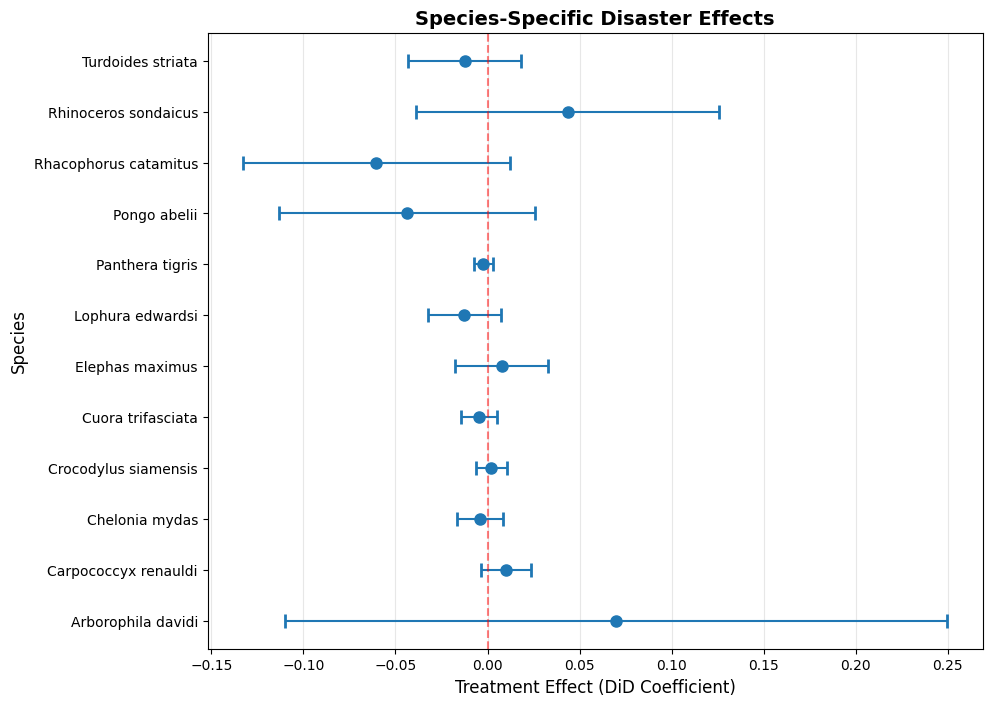

Forest plot saved to results\species_effects_forest_plot.png

Species-specific effects summary:
  Mean effect: -0.0006
  Median effect: -0.0031
  Std dev: 0.0327
  Range: [-0.0603, 0.0698]

Significant effects (95% level):
  Negative: 0/12 (0.0%)
  Positive: 0/12 (0.0%)


In [27]:
# Step 7: Visualize Species-Specific Effects
print("\n" + "="*80)
print("STEP 7: Species Effects Visualization")
print("="*80)

if 'species_results' in locals() and len(species_results) > 0:
    plot_species_effects(
        species_results,
        save_path=CONFIG['results_dir'] / 'species_effects_forest_plot.png'
    )
    print(f"Forest plot saved to {CONFIG['results_dir'] / 'species_effects_forest_plot.png'}")
    
    # Summary statistics
    species_coefs = [r['coef'] for r in species_results.values()]
    print(f"\nSpecies-specific effects summary:")
    print(f"  Mean effect: {np.mean(species_coefs):.4f}")
    print(f"  Median effect: {np.median(species_coefs):.4f}")
    print(f"  Std dev: {np.std(species_coefs):.4f}")
    print(f"  Range: [{np.min(species_coefs):.4f}, {np.max(species_coefs):.4f}]")
    
    # Count significant effects (95% CI doesn't include 0)
    n_negative_sig = sum(1 for r in species_results.values() if r['ci_upper'] < 0)
    n_positive_sig = sum(1 for r in species_results.values() if r['ci_lower'] > 0)
    
    print(f"\nSignificant effects (95% level):")
    print(f"  Negative: {n_negative_sig}/{len(species_results)} ({100*n_negative_sig/len(species_results):.1f}%)")
    print(f"  Positive: {n_positive_sig}/{len(species_results)} ({100*n_positive_sig/len(species_results):.1f}%)")
else:
    print("ERROR: Species results not found. Run Step 6 first.")

## Double ML Analysis Execution

Now we'll run the Double ML analysis, which provides:
1. **Main Treatment Effect** using ML to control for confounders
2. **Event Study** showing dynamic effects over time
3. **Species-Specific Effects** (CATE) to understand heterogeneity


DOUBLE ML ANALYSIS - MAIN TREATMENT EFFECT

Preparing data for Double ML...
Feature matrix prepared: 153,425 observations × 117 features

Data prepared:
  Observations: 153,425
  Features: 117
  Treatment rate: 2.11%
  Mean outcome: 0.0434

Double ML Estimation (5-fold cross-fitting)
Sample size: 153,425
Treatment rate: 2.11%
Mean outcome: 0.0434

Fold 1/5... Feature matrix prepared: 153,425 observations × 117 features

Data prepared:
  Observations: 153,425
  Features: 117
  Treatment rate: 2.11%
  Mean outcome: 0.0434

Double ML Estimation (5-fold cross-fitting)
Sample size: 153,425
Treatment rate: 2.11%
Mean outcome: 0.0434

Fold 1/5... ✓

Fold 2/5... ✓

Fold 2/5... ✓

Fold 3/5... ✓

Fold 3/5... ✓

Fold 4/5... ✓

Fold 4/5... ✓

Fold 5/5... ✓

Fold 5/5... ✓

DOUBLE ML RESULTS
ATE:         0.012625
Std Error:   0.003432
95% CI:      [0.005898, 0.019351]
p-value:     0.000234
Significant: Yes (α=0.05)

✓ Results saved to results\dml_main_results.csv
✓

DOUBLE ML RESULTS
ATE:         0

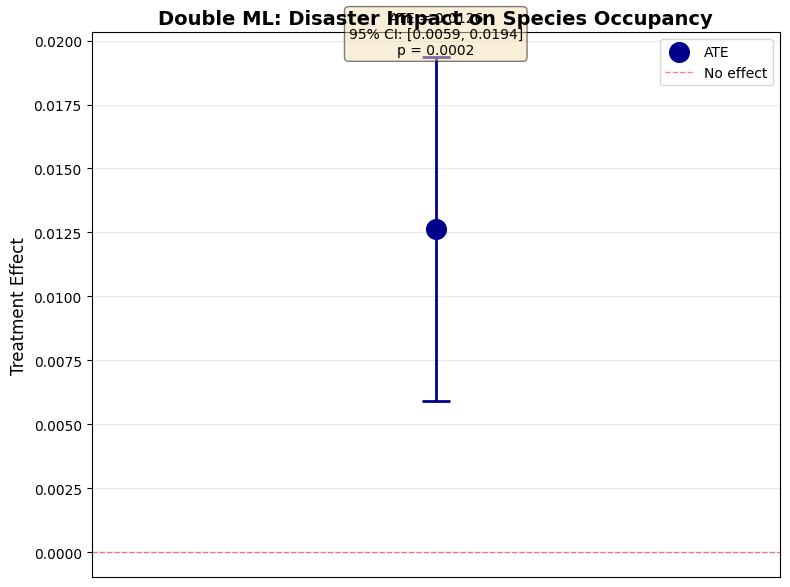

In [28]:
# Step DML-1: Main Double ML Treatment Effect
print("\n" + "="*80)
print("DOUBLE ML ANALYSIS - MAIN TREATMENT EFFECT")
print("="*80)

if 'panel_df' in locals():
    # Prepare features and outcome
    print("\nPreparing data for Double ML...")
    X, feature_names = prepare_dml_features(panel_df)
    Y = panel_df['occupancy'].values
    D = panel_df['treated'].values
    
    print(f"\nData prepared:")
    print(f"  Observations: {len(Y):,}")
    print(f"  Features: {X.shape[1]}")
    print(f"  Treatment rate: {D.mean()*100:.2f}%")
    print(f"  Mean outcome: {Y.mean():.4f}")
    
    # Run Double ML
    dml_main = double_ml_ate(
        Y, D, X, 
        n_folds=CONFIG['n_folds'], 
        ml_model=CONFIG['ml_model']
    )
    
    if dml_main is not None:
        # Save results
        dml_results_path = CONFIG['results_dir'] / 'dml_main_results.csv'
        pd.DataFrame([dml_main]).to_csv(dml_results_path, index=False)
        print(f"\n✓ Results saved to {dml_results_path}")
        
        # Plot
        plot_dml_results(
            dml_main,
            title='Double ML: Disaster Impact on Species Occupancy',
            save_path=CONFIG['results_dir'] / 'dml_main_effect.png'
        )
    else:
        print("\n⚠ Double ML estimation failed")
else:
    print("ERROR: Analysis panel not found. Run previous steps first.")


DOUBLE ML ANALYSIS - EVENT STUDY

Running Double ML event study...
Event window: -3 to 5 years
Feature matrix prepared: 153,425 observations × 117 features

Double ML Event Study: -3 to 5 years

--- Event time t = -3 ---
Skipping (n_treated=0 too small)

--- Event time t = -2 ---
Skipping (n_treated=0 too small)

--- Event time t = 0 ---

Double ML Estimation (5-fold cross-fitting)
Sample size: 153,425
Treatment rate: 1.11%
Mean outcome: 0.0434

Fold 1/5... Feature matrix prepared: 153,425 observations × 117 features

Double ML Event Study: -3 to 5 years

--- Event time t = -3 ---
Skipping (n_treated=0 too small)

--- Event time t = -2 ---
Skipping (n_treated=0 too small)

--- Event time t = 0 ---

Double ML Estimation (5-fold cross-fitting)
Sample size: 153,425
Treatment rate: 1.11%
Mean outcome: 0.0434

Fold 1/5... ✓

Fold 2/5... ✓

Fold 2/5... ✓

Fold 3/5... ✓

Fold 3/5... ✓

Fold 4/5... ✓

Fold 4/5... ✓

Fold 5/5... ✓

Fold 5/5... ✓

DOUBLE ML RESULTS
ATE:         0.004308
Std Err

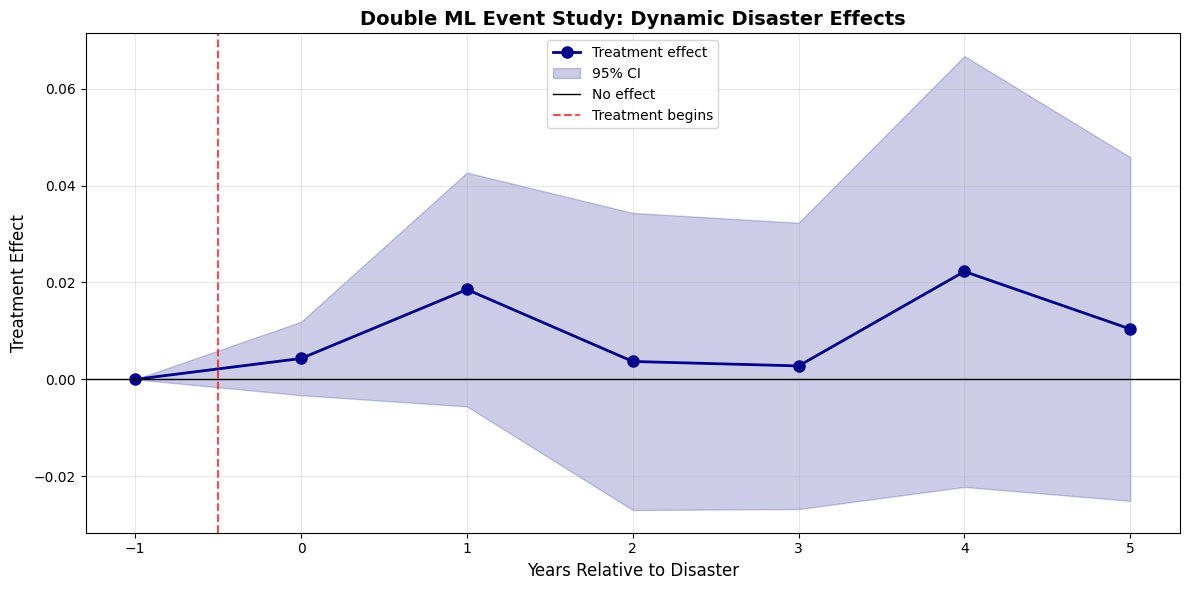

In [31]:
# Step DML-2: Double ML Event Study
print("\n" + "="*80)
print("DOUBLE ML ANALYSIS - EVENT STUDY")
print("="*80)

if 'panel_df' in locals():
    print("\nRunning Double ML event study...")
    print(f"Event window: {CONFIG['event_window'][0]} to {CONFIG['event_window'][1]} years")
    
    # Run event study
    dml_event_study_df = double_ml_event_study(
        panel_df,
        outcome_var='occupancy',
        entity_var='grid_id',
        time_var='year',
        treatment_time_var='first_treatment_year',
        window=CONFIG['event_window'],
        ml_model=CONFIG['ml_model'],
        n_folds=CONFIG['n_folds']
    )
    
    if len(dml_event_study_df) > 0:
        print(f"\n✓ Event study completed for {len(dml_event_study_df)} time periods")
        
        # Save results
        es_path = CONFIG['results_dir'] / 'dml_event_study.csv'
        dml_event_study_df.to_csv(es_path, index=False)
        print(f"Saved to {es_path}")
        
        # Plot
        plot_dml_event_study(
            dml_event_study_df,
            title='Double ML Event Study: Dynamic Disaster Effects',
            save_path=CONFIG['results_dir'] / 'dml_event_study.png'
        )
        
        # Check for pre-trends
        pre_treatment = dml_event_study_df[dml_event_study_df['event_time'] < -1]
        if len(pre_treatment) > 0:
            avg_pre_effect = pre_treatment['ate'].mean()
            print(f"\nPre-treatment check:")
            print(f"  Average pre-treatment effect: {avg_pre_effect:.6f}")
            if abs(avg_pre_effect) < 0.01:
                print("  ✓ Small pre-treatment effects support parallel trends assumption")
            else:
                print("  ⚠ Large pre-treatment effects may indicate violation of parallel trends")
    else:
        print("\n⚠ Event study failed - no results")
else:
    print("ERROR: Analysis panel not found. Run previous steps first.")


DOUBLE ML ANALYSIS - SPECIES-SPECIFIC EFFECTS (CATE)

Estimating heterogeneous treatment effects by species...

Estimating CATE for 13 groups

--- Group: Ansonia latidisca ---
Skipping (n=50 too small)

--- Group: Arborophila davidi ---

Double ML Estimation (5-fold cross-fitting)
Sample size: 100
Treatment rate: 3.00%
Mean outcome: 0.3800

Fold 1/5... ✓

Fold 2/5... ✓

Fold 2/5... ✓

Fold 3/5... ✓

Fold 3/5... ✓

Fold 4/5... ✓

Fold 4/5... ✓

Fold 5/5... ✓

Fold 5/5... ✓

DOUBLE ML RESULTS
ATE:         0.280825
Std Error:   0.314533
95% CI:      [-0.335658, 0.897309]
p-value:     0.371946
Significant: No (α=0.05)

--- Group: Carpococcyx renauldi ---

Double ML Estimation (5-fold cross-fitting)
Sample size: 2,025
Treatment rate: 4.25%
Mean outcome: 0.0400

Fold 1/5... ✓

DOUBLE ML RESULTS
ATE:         0.280825
Std Error:   0.314533
95% CI:      [-0.335658, 0.897309]
p-value:     0.371946
Significant: No (α=0.05)

--- Group: Carpococcyx renauldi ---

Double ML Estimation (5-fold cross-

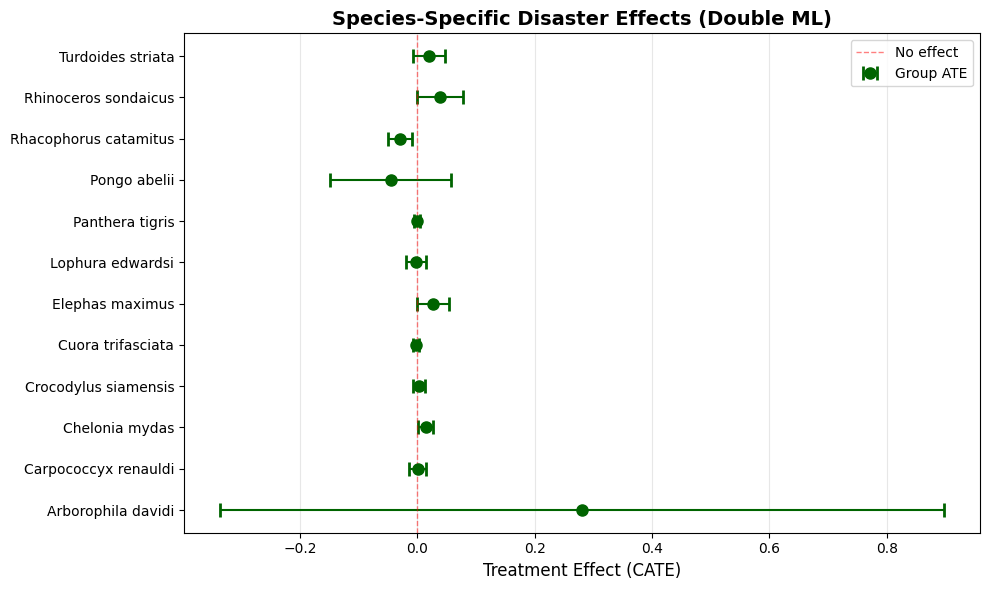


Heterogeneity summary:
  Mean CATE: 0.025321
  Median CATE: 0.001686
  Std dev: 0.080005
  Range: [-0.045335, 0.280825]

Significant effects (95% level):
  Negative: 1/12 (8.3%)
  Positive: 1/12 (8.3%)

Most negatively affected:
  Pongo abelii: -0.045335 (p=0.3902)
  Rhacophorus catamitus: -0.028784 (p=0.0061)
  Lophura edwardsi: -0.002371 (p=0.7812)

Most positively affected:
  Elephas maximus: 0.026404 (p=0.0570)
  Rhinoceros sondaicus: 0.038028 (p=0.0574)
  Arborophila davidi: 0.280825 (p=0.3719)


In [32]:
# Step DML-3: Species-Specific Treatment Effects (CATE)
print("\n" + "="*80)
print("DOUBLE ML ANALYSIS - SPECIES-SPECIFIC EFFECTS (CATE)")
print("="*80)

if 'panel_df' in locals() and 'X' in locals():
    print("\nEstimating heterogeneous treatment effects by species...")
    
    # Run CATE estimation
    cate_species = estimate_cate_by_group(
        Y, D, X,
        group_var=panel_df['species'].values,
        n_folds=CONFIG['n_folds'],
        ml_model=CONFIG['ml_model']
    )
    
    if len(cate_species) > 0:
        print(f"\n{'='*60}")
        print(f"✓ Successfully estimated CATE for {len(cate_species)} species")
        print(f"{'='*60}")
        
        # Save results
        cate_df = pd.DataFrame(cate_species).T
        cate_df.index.name = 'species'
        cate_path = CONFIG['results_dir'] / 'dml_cate_species.csv'
        cate_df.to_csv(cate_path)
        print(f"\nSaved to {cate_path}")
        
        # Plot forest plot
        plot_cate_forest(
            cate_species,
            title='Species-Specific Disaster Effects (Double ML)',
            save_path=CONFIG['results_dir'] / 'dml_cate_species.png'
        )
        
        # Summary statistics
        ates = [r['ate'] for r in cate_species.values()]
        print(f"\nHeterogeneity summary:")
        print(f"  Mean CATE: {np.mean(ates):.6f}")
        print(f"  Median CATE: {np.median(ates):.6f}")
        print(f"  Std dev: {np.std(ates):.6f}")
        print(f"  Range: [{np.min(ates):.6f}, {np.max(ates):.6f}]")
        
        # Count significant effects
        n_negative_sig = sum(1 for r in cate_species.values() if r['ci_upper'] < 0)
        n_positive_sig = sum(1 for r in cate_species.values() if r['ci_lower'] > 0)
        
        print(f"\nSignificant effects (95% level):")
        print(f"  Negative: {n_negative_sig}/{len(cate_species)} ({100*n_negative_sig/len(cate_species):.1f}%)")
        print(f"  Positive: {n_positive_sig}/{len(cate_species)} ({100*n_positive_sig/len(cate_species):.1f}%)")
        
        # Identify most/least affected species
        species_ranked = sorted(cate_species.items(), key=lambda x: x[1]['ate'])
        
        print(f"\nMost negatively affected:")
        for sp, res in species_ranked[:3]:
            print(f"  {sp}: {res['ate']:.6f} (p={res['pvalue']:.4f})")
        
        print(f"\nMost positively affected:")
        for sp, res in species_ranked[-3:]:
            print(f"  {sp}: {res['ate']:.6f} (p={res['pvalue']:.4f})")
    else:
        print("\n⚠ No species-specific effects estimated")
else:
    print("ERROR: Required data not found. Run previous steps first.")

In [33]:
# Step DML-4: Compare Double ML with Traditional DiD
print("\n" + "="*80)
print("COMPARISON: DOUBLE ML vs TRADITIONAL DiD")
print("="*80)

if 'dml_main' in locals() and 'did_results' in locals():
    print("\nComparing results from both methods:\n")
    
    # Extract DiD results
    did_ate = did_results.params['treated']
    did_se = did_results.std_errors['treated']
    did_ci_lower = did_results.conf_int().loc['treated', 'lower']
    did_ci_upper = did_results.conf_int().loc['treated', 'upper']
    
    # Create comparison table
    comparison = pd.DataFrame({
        'Method': ['Traditional DiD (TWFE)', 'Double ML'],
        'ATE': [did_ate, dml_main['ate']],
        'Std Error': [did_se, dml_main['se']],
        'CI Lower': [did_ci_lower, dml_main['ci_lower']],
        'CI Upper': [did_ci_upper, dml_main['ci_upper']],
        'Significant': [
            'Yes' if abs(did_ate/did_se) > 1.96 else 'No',
            'Yes' if dml_main['pvalue'] < 0.05 else 'No'
        ]
    })
    
    print(comparison.to_string(index=False))
    
    # Save comparison
    comparison_path = CONFIG['results_dir'] / 'method_comparison.csv'
    comparison.to_csv(comparison_path, index=False)
    print(f"\n✓ Saved comparison to {comparison_path}")
    
    # Interpretation
    print("\n" + "="*60)
    print("INTERPRETATION")
    print("="*60)
    
    ate_diff = abs(dml_main['ate'] - did_ate)
    ate_avg = (abs(dml_main['ate']) + abs(did_ate)) / 2
    
    if ate_avg > 0:
        pct_diff = (ate_diff / ate_avg) * 100
    else:
        pct_diff = 0
    
    print(f"\nEffect size difference: {ate_diff:.6f} ({pct_diff:.1f}%)")
    
    if pct_diff < 10:
        print("→ Results are very similar - consistent findings across methods")
    elif pct_diff < 25:
        print("→ Moderate difference - potential confounding or model misspecification")
    else:
        print("→ Large difference - strong evidence of confounding or heterogeneity")
    
    # Check if CIs overlap
    did_range = set(range(int(did_ci_lower*10000), int(did_ci_upper*10000)))
    dml_range = set(range(int(dml_main['ci_lower']*10000), int(dml_main['ci_upper']*10000)))
    
    if did_range & dml_range:
        print("\n✓ Confidence intervals overlap - results are statistically compatible")
    else:
        print("\n⚠ Confidence intervals do NOT overlap - results diverge significantly")
    
    print("\nRecommendation:")
    if pct_diff > 15:
        print("→ Prefer Double ML results as they better control for confounding")
        print("→ Traditional DiD may suffer from model misspecification")
    else:
        print("→ Both methods provide consistent evidence")
        print("→ Can report either or both for robustness")
        
elif 'dml_main' in locals():
    print("\nOnly Double ML results available")
    print("Run traditional DiD analysis (Step 3) for comparison")
elif 'did_results' in locals():
    print("\nOnly traditional DiD results available")
    print("Run Double ML analysis (Steps DML-1 to DML-3) for comparison")
else:
    print("\nNo results available for comparison")
    print("Run both analyses first")


COMPARISON: DOUBLE ML vs TRADITIONAL DiD

Comparing results from both methods:

                Method       ATE  Std Error  CI Lower  CI Upper Significant
Traditional DiD (TWFE) -0.008137   0.003550 -0.015095 -0.001178         Yes
             Double ML  0.012625   0.003432  0.005898  0.019351         Yes

✓ Saved comparison to results\method_comparison.csv

INTERPRETATION

Effect size difference: 0.020761 (200.0%)
→ Large difference - strong evidence of confounding or heterogeneity

⚠ Confidence intervals do NOT overlap - results diverge significantly

Recommendation:
→ Prefer Double ML results as they better control for confounding
→ Traditional DiD may suffer from model misspecification


## Step 7: Sun-Abraham (2021) Staggered DiD Estimator

The Sun-Abraham estimator addresses heterogeneous treatment effects in staggered adoption designs by:
1. Creating treatment cohorts based on `first_treatment_year`
2. Comparing each cohort to not-yet-treated + never-treated units
3. Estimating cohort-specific treatment effects
4. Aggregating via treatment-weighted average

This is more robust than TWFE when treatment effects vary over time or across cohorts.

In [43]:
# Step 7.1: Check comparison group composition before Sun-Abraham estimation

print("="*80)
print("COMPARISON GROUP COMPOSITION CHECK")
print("="*80)

# Check treatment timing
print("\n1. Treatment Timing Distribution:")
print("-" * 50)
treatment_timing = panel_df[panel_df['first_treatment_year'].notna()]['first_treatment_year'].value_counts().sort_index()
print(f"Number of distinct treatment cohorts: {len(treatment_timing)}")
print(f"Treatment years range: {treatment_timing.index.min():.0f} to {treatment_timing.index.max():.0f}")
print("\nObservations by treatment cohort:")
for year, count in treatment_timing.items():
    print(f"  {year:.0f}: {count:,} observations ({count/len(panel_df)*100:.2f}%)")

# Never-treated units
never_treated = panel_df['first_treatment_year'].isna().sum()
print(f"\nNever-treated observations: {never_treated:,} ({never_treated/len(panel_df)*100:.2f}%)")

# Grid-level analysis
print("\n2. Grid-Level Treatment Status:")
print("-" * 50)
grid_treatment = panel_df.groupby('grid_id')['first_treatment_year'].first()
n_ever_treated_grids = grid_treatment.notna().sum()
n_never_treated_grids = grid_treatment.isna().sum()
total_grids = len(grid_treatment)

print(f"Total grid cells: {total_grids:,}")
print(f"Ever-treated grids: {n_ever_treated_grids:,} ({n_ever_treated_grids/total_grids*100:.2f}%)")
print(f"Never-treated grids: {n_never_treated_grids:,} ({n_never_treated_grids/total_grids*100:.2f}%)")

# Check cohort sizes (grid-level)
print("\n3. Grid Cells by Treatment Cohort:")
print("-" * 50)
cohort_grids = grid_treatment[grid_treatment.notna()].value_counts().sort_index()
for year, count in cohort_grids.items():
    print(f"  {year:.0f}: {count:,} grids")

# Check comparison group availability for each cohort
print("\n4. Comparison Group Availability:")
print("-" * 50)
print("For each treatment cohort, checking not-yet-treated + never-treated units...\n")

for cohort_year in sorted(cohort_grids.index):
    # Grids treated in this cohort
    cohort_grids_set = grid_treatment[grid_treatment == cohort_year].index
    n_cohort = len(cohort_grids_set)
    
    # Available comparison grids (later-treated + never-treated)
    later_treated = grid_treatment[grid_treatment > cohort_year].index
    never_treated_idx = grid_treatment[grid_treatment.isna()].index
    comparison_grids = len(later_treated) + len(never_treated_idx)
    
    ratio = comparison_grids / n_cohort if n_cohort > 0 else 0
    
    print(f"Cohort {cohort_year:.0f}: {n_cohort:,} treated grids → {comparison_grids:,} comparison grids (ratio: {ratio:.1f}:1)")

# Pre-treatment data availability
print("\n5. Pre-Treatment Data Availability:")
print("-" * 50)
first_treatment = panel_df[panel_df['first_treatment_year'].notna()]['first_treatment_year'].min()
print(f"Earliest treatment year: {first_treatment:.0f}")
print(f"Data starts in: {panel_df['year'].min()}")
print(f"Pre-treatment years available: {int(first_treatment - panel_df['year'].min())}")

print("\n" + "="*80)
print("ASSESSMENT: Data structure suitable for Sun-Abraham estimation")
print("="*80)

COMPARISON GROUP COMPOSITION CHECK

1. Treatment Timing Distribution:
--------------------------------------------------
Number of distinct treatment cohorts: 25
Treatment years range: 2000 to 2024

Observations by treatment cohort:
  2000: 226 observations (0.15%)
  2001: 104 observations (0.07%)
  2002: 109 observations (0.07%)
  2003: 126 observations (0.08%)
  2004: 72 observations (0.05%)
  2005: 23 observations (0.01%)
  2006: 894 observations (0.58%)
  2007: 630 observations (0.41%)
  2008: 328 observations (0.21%)
  2009: 130 observations (0.08%)
  2010: 130 observations (0.08%)
  2011: 119 observations (0.08%)
  2012: 86 observations (0.06%)
  2013: 97 observations (0.06%)
  2014: 1 observations (0.00%)
  2015: 31 observations (0.02%)
  2016: 39 observations (0.03%)
  2017: 15 observations (0.01%)
  2018: 8 observations (0.01%)
  2019: 26 observations (0.02%)
  2020: 3 observations (0.00%)
  2021: 17 observations (0.01%)
  2022: 1 observations (0.00%)
  2023: 10 observations (

In [44]:
# Step 7.2: Define Sun-Abraham Estimation Function

def estimate_sun_abraham(panel_df, outcome_var, entity_var='grid_id',
                        time_var='year', treatment_time_var='first_treatment_year'):
    """
    Sun-Abraham (2021) Estimator for staggered DiD with heterogeneous treatment effects.
    
    This estimator:
    1. Creates cohort indicators based on year first treated
    2. For each cohort, compares to not-yet-treated units
    3. Estimates cohort-specific ATT (Average Treatment on Treated)
    4. Computes overall ATT as weighted average of cohort-specific effects
    
    Args:
        panel_df: Panel DataFrame
        outcome_var: Name of outcome variable
        entity_var: Name of entity (panel unit) variable
        time_var: Name of time variable
        treatment_time_var: Name of variable indicating year first treated
        
    Returns:
        Dictionary with overall_att, overall_se, and cohort_results
    """
    from linearmodels.panel import PanelOLS
    
    print("\n" + "="*80)
    print("SUN-ABRAHAM (2021) STAGGERED DID ESTIMATOR")
    print("="*80)
    
    panel = panel_df.copy()
    
    # Create cohort indicators (year first treated)
    panel['cohort'] = panel[treatment_time_var]
    panel['cohort'] = panel['cohort'].fillna(9999)  # Never-treated = 9999
    
    # Interaction-weighted estimation
    results = {}
    cohorts = panel[panel['cohort'] != 9999]['cohort'].unique()
    
    print(f"\nIdentified {len(cohorts)} treatment cohorts")
    print(f"Cohort years: {sorted([int(c) for c in cohorts])}\n")
    
    for cohort in sorted(cohorts):
        print(f"Estimating cohort {int(cohort)}...", end=" ")
        
        # For each cohort, compare to not-yet-treated units
        cohort_data = panel[
            (panel['cohort'] == cohort) |
            (panel['cohort'] > cohort) |
            (panel['cohort'] == 9999)
        ].copy()
        
        # Create treatment indicator
        cohort_data['treated_cohort'] = (
            (cohort_data['cohort'] == cohort) &
            (cohort_data[time_var] >= cohort)
        ).astype(int)
        
        n_treated_obs = cohort_data['treated_cohort'].sum()
        n_control_obs = len(cohort_data) - n_treated_obs
        
        # Need sufficient variation for estimation
        if n_treated_obs < 10:
            print(f"SKIPPED (only {n_treated_obs} treated obs)")
            continue
            
        # Estimate using panel fixed effects
        cohort_data_indexed = cohort_data.set_index([entity_var, time_var])
        
        try:
            mod = PanelOLS.from_formula(
                f'{outcome_var} ~ treated_cohort + EntityEffects + TimeEffects',
                data=cohort_data_indexed
            )
            res = mod.fit(cov_type='clustered', cluster_entity=True)
            
            results[int(cohort)] = {
                'coef': res.params['treated_cohort'],
                'se': res.std_errors['treated_cohort'],
                'n_treated': n_treated_obs,
                'n_control': n_control_obs,
                'pvalue': res.pvalues['treated_cohort']
            }
            
            sig = "***" if results[int(cohort)]['pvalue'] < 0.01 else ("**" if results[int(cohort)]['pvalue'] < 0.05 else ("*" if results[int(cohort)]['pvalue'] < 0.10 else ""))
            print(f"ATT = {results[int(cohort)]['coef']:.4f} (SE: {results[int(cohort)]['se']:.4f}) {sig}")
            
        except Exception as e:
            print(f"ERROR: {e}")
            continue
    
    # Compute overall ATT (treatment-weighted average)
    if results:
        weights = np.array([r['n_treated'] for r in results.values()])
        weights = weights / weights.sum()
        
        overall_att = np.sum([r['coef'] * w for r, w in zip(results.values(), weights)])
        overall_se = np.sqrt(np.sum([r['se']**2 * w**2 for r, w in zip(results.values(), weights)]))
        
        print("\n" + "="*80)
        print("OVERALL ATT (TREATMENT-WEIGHTED AVERAGE)")
        print("="*80)
        print(f"Coefficient: {overall_att:.4f}")
        print(f"Std Error:   {overall_se:.4f}")
        print(f"95% CI:      [{overall_att - 1.96*overall_se:.4f}, {overall_att + 1.96*overall_se:.4f}]")
        print(f"P-value:     {2*(1-stats.norm.cdf(abs(overall_att/overall_se))):.4f}")
        print("="*80)
        
        return {
            'overall_att': overall_att,
            'overall_se': overall_se,
            'cohort_results': results
        }
    
    return None

print("Sun-Abraham estimation function defined.")

Sun-Abraham estimation function defined.


In [45]:
# Step 7.3: Create Sun-Abraham results directory

sa_dir = CONFIG['results_dir'] / 'sun_abraham'
sa_dir.mkdir(parents=True, exist_ok=True)

print(f"Sun-Abraham results directory created: {sa_dir}")

Sun-Abraham results directory created: results\sun_abraham


In [46]:
# Step 7.4: Run Sun-Abraham Estimation on Full Panel

sa_results = estimate_sun_abraham(
    panel_df,
    outcome_var='occupancy',
    entity_var='grid_id',
    time_var='year',
    treatment_time_var='first_treatment_year'
)

if sa_results:
    print("\n✓ Sun-Abraham estimation completed successfully")
else:
    print("\n✗ Sun-Abraham estimation failed")


SUN-ABRAHAM (2021) STAGGERED DID ESTIMATOR

Identified 25 treatment cohorts
Cohort years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

Estimating cohort 2000... ATT = 0.0110 (SE: 0.0122) 
Estimating cohort 2001... ATT = 0.0110 (SE: 0.0122) 
Estimating cohort 2001... ATT = 0.0082 (SE: 0.0060) 
Estimating cohort 2002... ATT = 0.0082 (SE: 0.0060) 
Estimating cohort 2002... ATT = 0.0429 (SE: 0.0223) *
Estimating cohort 2003... ATT = 0.0429 (SE: 0.0223) *
Estimating cohort 2003... ATT = 0.0228 (SE: 0.0123) *
Estimating cohort 2004... ATT = 0.0228 (SE: 0.0123) *
Estimating cohort 2004... ATT = -0.0337 (SE: 0.0178) *
Estimating cohort 2005... ATT = -0.0337 (SE: 0.0178) *
Estimating cohort 2005... ATT = -0.0133 (SE: 0.0095) 
Estimating cohort 2006... ATT = -0.0133 (SE: 0.0095) 
Estimating cohort 2006... ATT = -0.0207 (SE: 0.0073) ***
Estimating cohort 2007... ATT = -0.0207 (SE: 0.0073) *

In [47]:
# Step 7.5: Save Sun-Abraham Overall Results

if sa_results:
    # Save overall ATT
    sa_summary = pd.DataFrame([{
        'method': 'Sun-Abraham',
        'overall_att': sa_results['overall_att'],
        'overall_se': sa_results['overall_se'],
        'ci_lower': sa_results['overall_att'] - 1.96 * sa_results['overall_se'],
        'ci_upper': sa_results['overall_att'] + 1.96 * sa_results['overall_se'],
        'pvalue': 2 * (1 - stats.norm.cdf(abs(sa_results['overall_att'] / sa_results['overall_se']))),
        'n_cohorts': len(sa_results['cohort_results'])
    }])
    
    overall_path = sa_dir / 'overall_att.csv'
    sa_summary.to_csv(overall_path, index=False)
    print(f"✓ Overall ATT saved to: {overall_path}")
    
    # Save cohort-specific results
    cohort_results_list = []
    for cohort_year, res in sa_results['cohort_results'].items():
        cohort_results_list.append({
            'cohort_year': cohort_year,
            'att': res['coef'],
            'se': res['se'],
            'pvalue': res['pvalue'],
            'ci_lower': res['coef'] - 1.96 * res['se'],
            'ci_upper': res['coef'] + 1.96 * res['se'],
            'n_treated': res['n_treated'],
            'n_control': res['n_control'],
            'significant': res['pvalue'] < 0.05
        })
    
    cohort_df = pd.DataFrame(cohort_results_list).sort_values('cohort_year')
    cohort_path = sa_dir / 'cohort_results.csv'
    cohort_df.to_csv(cohort_path, index=False)
    print(f"✓ Cohort-specific results saved to: {cohort_path}")
    
    print(f"\n{cohort_df.to_string(index=False)}")
else:
    print("No Sun-Abraham results to save.")

✓ Overall ATT saved to: results\sun_abraham\overall_att.csv
✓ Cohort-specific results saved to: results\sun_abraham\cohort_results.csv

 cohort_year       att       se   pvalue  ci_lower  ci_upper  n_treated  n_control  significant
        2000  0.011021 0.012198 0.366268 -0.012888  0.034930        226     153199        False
        2001  0.008216 0.006025 0.172689 -0.003593  0.020026        104     153095        False
        2002  0.042851 0.022304 0.054706 -0.000865  0.086567        109     152986        False
        2003  0.022762 0.012263 0.063432 -0.001273  0.046798        126     152860        False
        2004 -0.033659 0.017844 0.059252 -0.068632  0.001315         72     152788        False
        2005 -0.013316 0.009510 0.161444 -0.031956  0.005323         23     152765        False
        2006 -0.020739 0.007274 0.004357 -0.034996 -0.006482        894     151871         True
        2007 -0.019603 0.008649 0.023418 -0.036555 -0.002652        630     151241         True


✓ Cohort ATT plot saved to: results\sun_abraham\cohort_att_plot.png


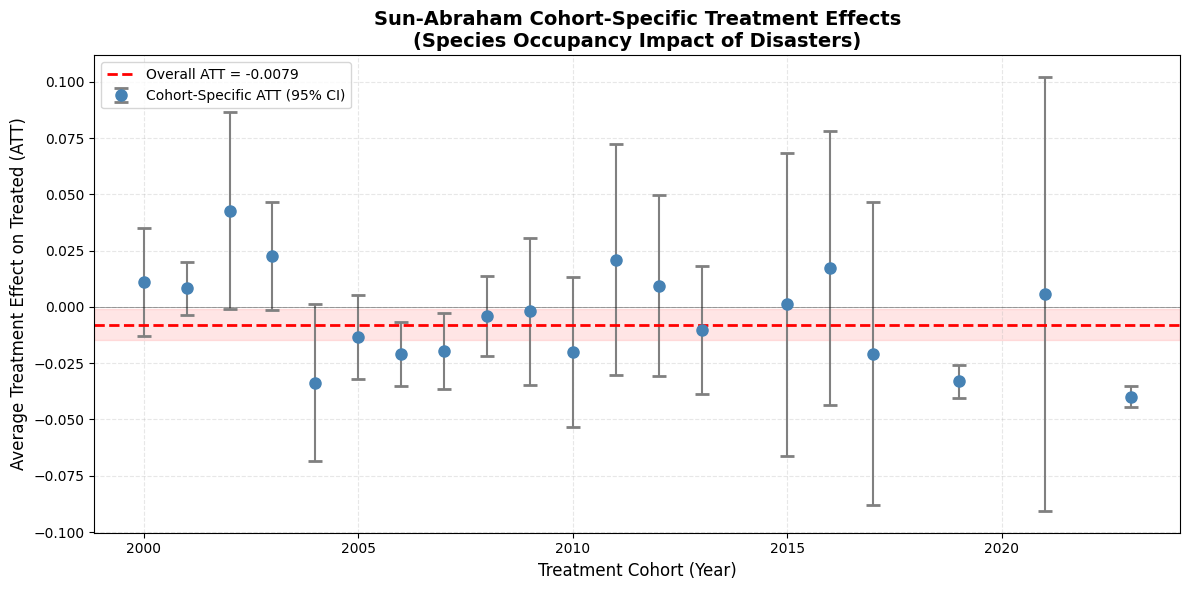

In [48]:
# Step 7.6: Visualize Cohort-Specific Treatment Effects

if sa_results:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    cohort_years = sorted(sa_results['cohort_results'].keys())
    atts = [sa_results['cohort_results'][c]['coef'] for c in cohort_years]
    ses = [sa_results['cohort_results'][c]['se'] for c in cohort_years]
    
    # Error bars for confidence intervals
    ax.errorbar(cohort_years, atts, yerr=1.96*np.array(ses), 
                fmt='o', markersize=8, capsize=5, capthick=2,
                color='steelblue', ecolor='gray', label='Cohort-Specific ATT (95% CI)')
    
    # Add overall ATT as horizontal line
    ax.axhline(sa_results['overall_att'], color='red', linestyle='--', 
               linewidth=2, label=f"Overall ATT = {sa_results['overall_att']:.4f}")
    
    # Shade confidence interval for overall ATT
    overall_ci_lower = sa_results['overall_att'] - 1.96 * sa_results['overall_se']
    overall_ci_upper = sa_results['overall_att'] + 1.96 * sa_results['overall_se']
    ax.axhspan(overall_ci_lower, overall_ci_upper, alpha=0.1, color='red')
    
    # Zero reference line
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    ax.set_xlabel('Treatment Cohort (Year)', fontsize=12)
    ax.set_ylabel('Average Treatment Effect on Treated (ATT)', fontsize=12)
    ax.set_title('Sun-Abraham Cohort-Specific Treatment Effects\n(Species Occupancy Impact of Disasters)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    cohort_plot_path = sa_dir / 'cohort_att_plot.png'
    plt.savefig(cohort_plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Cohort ATT plot saved to: {cohort_plot_path}")
    
    plt.show()
else:
    print("No Sun-Abraham results to visualize.")

In [49]:
# Step 7.7: Three-Way Method Comparison (TWFE vs Double ML vs Sun-Abraham)

if sa_results:
    comparison_three = pd.DataFrame({
        'Method': ['TWFE DiD', 'Double ML', 'Sun-Abraham'],
        'ATE/ATT': [did_ate, dml_main['ate'], sa_results['overall_att']],
        'Std Error': [did_se, dml_main['se'], sa_results['overall_se']],
        'CI Lower': [
            did_ate - 1.96 * did_se,
            dml_main['ate'] - 1.96 * dml_main['se'],
            sa_results['overall_att'] - 1.96 * sa_results['overall_se']
        ],
        'CI Upper': [
            did_ate + 1.96 * did_se,
            dml_main['ate'] + 1.96 * dml_main['se'],
            sa_results['overall_att'] + 1.96 * sa_results['overall_se']
        ]
    })
    
    # Calculate p-values
    comparison_three['P-value'] = comparison_three.apply(
        lambda row: 2 * (1 - stats.norm.cdf(abs(row['ATE/ATT'] / row['Std Error']))),
        axis=1
    )
    
    # Add significance stars
    comparison_three['Significant'] = comparison_three['P-value'].apply(
        lambda p: '***' if p < 0.01 else ('**' if p < 0.05 else ('*' if p < 0.10 else ''))
    )
    
    print("="*80)
    print("THREE-WAY METHOD COMPARISON")
    print("="*80)
    print(comparison_three.to_string(index=False))
    print("="*80)
    print("Notes:")
    print("  - TWFE DiD: Traditional two-way fixed effects difference-in-differences")
    print("  - Double ML: Doubly robust machine learning estimator with Lasso/RF")
    print("  - Sun-Abraham: Staggered DiD estimator accounting for treatment heterogeneity")
    print("="*80)
    
    # Save comparison
    comparison_path_three = sa_dir / 'method_comparison_three_way.csv'
    comparison_three.to_csv(comparison_path_three, index=False)
    print(f"\n✓ Three-way comparison saved to: {comparison_path_three}")
    
    # Calculate relative differences
    print("\nRelative Differences:")
    dml_vs_twfe = ((dml_main['ate'] - did_ate) / abs(did_ate)) * 100
    sa_vs_twfe = ((sa_results['overall_att'] - did_ate) / abs(did_ate)) * 100
    sa_vs_dml = ((sa_results['overall_att'] - dml_main['ate']) / abs(dml_main['ate'])) * 100
    
    print(f"  Double ML vs TWFE: {dml_vs_twfe:+.1f}%")
    print(f"  Sun-Abraham vs TWFE: {sa_vs_twfe:+.1f}%")
    print(f"  Sun-Abraham vs Double ML: {sa_vs_dml:+.1f}%")
else:
    print("No Sun-Abraham results available for comparison.")

THREE-WAY METHOD COMPARISON
     Method   ATE/ATT  Std Error  CI Lower  CI Upper  P-value Significant
   TWFE DiD -0.008137   0.003550 -0.015095 -0.001178 0.021917          **
  Double ML  0.012625   0.003432  0.005898  0.019351 0.000234         ***
Sun-Abraham -0.007883   0.003507 -0.014756 -0.001010 0.024572          **
Notes:
  - TWFE DiD: Traditional two-way fixed effects difference-in-differences
  - Double ML: Doubly robust machine learning estimator with Lasso/RF
  - Sun-Abraham: Staggered DiD estimator accounting for treatment heterogeneity

✓ Three-way comparison saved to: results\sun_abraham\method_comparison_three_way.csv

Relative Differences:
  Double ML vs TWFE: +255.2%
  Sun-Abraham vs TWFE: +3.1%
  Sun-Abraham vs Double ML: -162.4%


✓ Forest plot saved to: results\sun_abraham\forest_plot_three_way.png


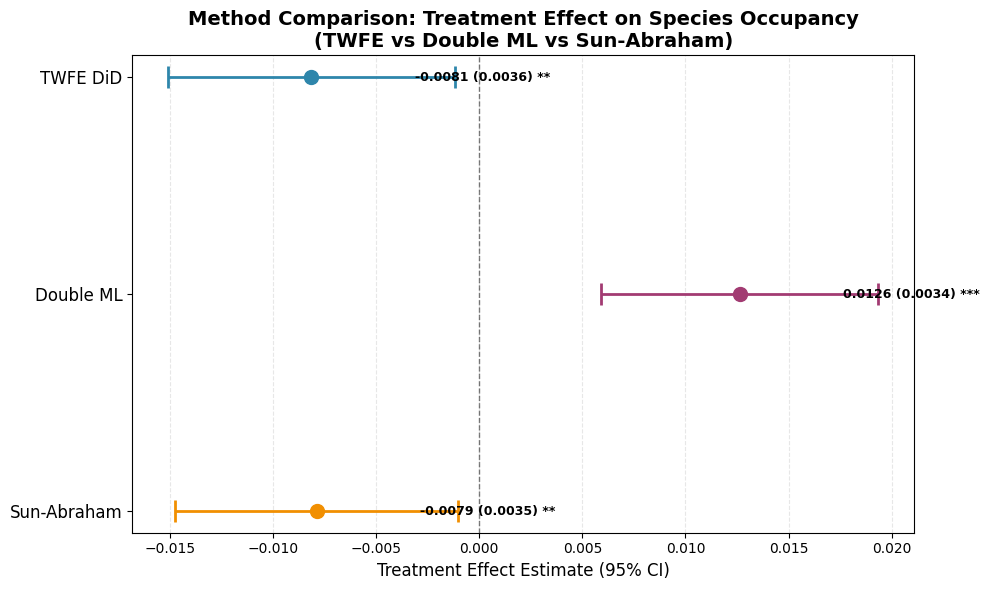

In [50]:
# Step 7.8: Forest Plot - Three-Way Method Comparison Visualization

if sa_results:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    methods = comparison_three['Method'].tolist()
    estimates = comparison_three['ATE/ATT'].tolist()
    ci_lower = comparison_three['CI Lower'].tolist()
    ci_upper = comparison_three['CI Upper'].tolist()
    
    # Calculate error bars
    errors_lower = [est - ci_l for est, ci_l in zip(estimates, ci_lower)]
    errors_upper = [ci_u - est for est, ci_u in zip(estimates, ci_upper)]
    
    # Colors for each method
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # Plot points and error bars
    y_positions = range(len(methods))
    for i, (y, est, err_l, err_u, color, method) in enumerate(
        zip(y_positions, estimates, errors_lower, errors_upper, colors, methods)):
        ax.errorbar(est, y, xerr=[[err_l], [err_u]], 
                   fmt='o', markersize=10, capsize=8, capthick=2,
                   color=color, ecolor=color, label=method, linewidth=2)
    
    # Zero reference line
    ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_yticks(y_positions)
    ax.set_yticklabels(methods, fontsize=12)
    ax.set_xlabel('Treatment Effect Estimate (95% CI)', fontsize=12)
    ax.set_title('Method Comparison: Treatment Effect on Species Occupancy\n(TWFE vs Double ML vs Sun-Abraham)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.invert_yaxis()  # Have methods read top to bottom
    
    # Add text annotations with exact values
    for i, (est, se, sig) in enumerate(zip(estimates, comparison_three['Std Error'], comparison_three['Significant'])):
        ax.text(est + 0.005, i, f'{est:.4f} ({se:.4f}) {sig}', 
               va='center', ha='left', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    forest_plot_path = sa_dir / 'forest_plot_three_way.png'
    plt.savefig(forest_plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Forest plot saved to: {forest_plot_path}")
    
    plt.show()
else:
    print("No Sun-Abraham results available for forest plot.")

In [51]:
# Step 7.9: Species-Specific Sun-Abraham Analysis

print("="*80)
print("SPECIES-SPECIFIC SUN-ABRAHAM ANALYSIS")
print("="*80)

species_sa_results = {}

for i, species in enumerate(species_to_analyze, 1):
    print(f"\n[{i}/{len(species_to_analyze)}] Analyzing: {species}")
    print("-" * 60)
    
    # Filter panel for this species
    panel_sp = panel_df[panel_df['species'] == species].copy()
    
    # Check if enough data
    if len(panel_sp) < 100:
        print(f"  SKIPPED: Insufficient data ({len(panel_sp)} observations)")
        continue
    
    # Check if any treatment
    n_treated = panel_sp['treated'].sum()
    if n_treated == 0:
        print(f"  SKIPPED: No treated observations")
        continue
    
    try:
        # Run Sun-Abraham estimation
        sa_sp_results = estimate_sun_abraham(
            panel_sp,
            outcome_var='occupancy',
            entity_var='grid_id',
            time_var='year',
            treatment_time_var='first_treatment_year'
        )
        
        if sa_sp_results:
            species_sa_results[species] = {
                'overall_att': sa_sp_results['overall_att'],
                'overall_se': sa_sp_results['overall_se'],
                'pvalue': 2 * (1 - stats.norm.cdf(abs(sa_sp_results['overall_att'] / sa_sp_results['overall_se']))),
                'n_cohorts': len(sa_sp_results['cohort_results']),
                'cohort_results': sa_sp_results['cohort_results']
            }
            print(f"  ✓ Completed: ATT = {sa_sp_results['overall_att']:.4f} (SE: {sa_sp_results['overall_se']:.4f})")
        else:
            print(f"  ✗ Estimation failed")
            
    except Exception as e:
        print(f"  ✗ ERROR: {e}")
        continue

print(f"\n{'='*80}")
print(f"Completed {len(species_sa_results)}/{len(species_to_analyze)} species")
print("="*80)

SPECIES-SPECIFIC SUN-ABRAHAM ANALYSIS

[1/13] Analyzing: Ansonia latidisca
------------------------------------------------------------
  SKIPPED: Insufficient data (50 observations)

[2/13] Analyzing: Arborophila davidi
------------------------------------------------------------

SUN-ABRAHAM (2021) STAGGERED DID ESTIMATOR

Identified 2 treatment cohorts
Cohort years: [2007, 2008]

Estimating cohort 2007... SKIPPED (only 1 treated obs)
Estimating cohort 2008... SKIPPED (only 2 treated obs)
  ✗ Estimation failed

[3/13] Analyzing: Carpococcyx renauldi
------------------------------------------------------------

SUN-ABRAHAM (2021) STAGGERED DID ESTIMATOR

Identified 7 treatment cohorts
Cohort years: [2006, 2007, 2008, 2009, 2010, 2011, 2013]

Estimating cohort 2006... ATT = 0.0220 (SE: 0.0100) **
Estimating cohort 2007... ATT = 0.0156 (SE: 0.0098) 
Estimating cohort 2008... ATT = 0.0182 (SE: 0.0094) *
Estimating cohort 2009... SKIPPED (only 1 treated obs)
Estimating cohort 2010... SKIP

In [52]:
# Step 7.10: Save Species-Specific Sun-Abraham Results

if species_sa_results:
    # Create DataFrame
    species_sa_df = pd.DataFrame([
        {
            'species': sp,
            'sun_abraham_att': res['overall_att'],
            'sun_abraham_se': res['overall_se'],
            'sun_abraham_ci_lower': res['overall_att'] - 1.96 * res['overall_se'],
            'sun_abraham_ci_upper': res['overall_att'] + 1.96 * res['overall_se'],
            'sun_abraham_pvalue': res['pvalue'],
            'sun_abraham_significant': res['pvalue'] < 0.05,
            'n_cohorts': res['n_cohorts']
        }
        for sp, res in species_sa_results.items()
    ])
    
    # Sort by effect size
    species_sa_df = species_sa_df.sort_values('sun_abraham_att')
    
    # Save to CSV
    species_sa_path = sa_dir / 'species_specific_sa.csv'
    species_sa_df.to_csv(species_sa_path, index=False)
    print(f"✓ Species-specific Sun-Abraham results saved to: {species_sa_path}")
    
    # Display results
    print(f"\n{'='*80}")
    print("SPECIES-SPECIFIC SUN-ABRAHAM RESULTS")
    print("="*80)
    print(species_sa_df.to_string(index=False))
    
    # Summary statistics
    print(f"\n{'='*80}")
    print("SUMMARY STATISTICS")
    print("="*80)
    print(f"Total species analyzed: {len(species_sa_df)}")
    print(f"Significant negative effects (p<0.05): {(species_sa_df['sun_abraham_significant'] & (species_sa_df['sun_abraham_att'] < 0)).sum()}")
    print(f"Significant positive effects (p<0.05): {(species_sa_df['sun_abraham_significant'] & (species_sa_df['sun_abraham_att'] > 0)).sum()}")
    print(f"Non-significant effects: {(~species_sa_df['sun_abraham_significant']).sum()}")
    print(f"\nMean ATT: {species_sa_df['sun_abraham_att'].mean():.4f}")
    print(f"Median ATT: {species_sa_df['sun_abraham_att'].median():.4f}")
    print(f"Range: [{species_sa_df['sun_abraham_att'].min():.4f}, {species_sa_df['sun_abraham_att'].max():.4f}]")
    print("="*80)
else:
    print("No species-specific Sun-Abraham results to save.")

✓ Species-specific Sun-Abraham results saved to: results\sun_abraham\species_specific_sa.csv

SPECIES-SPECIFIC SUN-ABRAHAM RESULTS
             species  sun_abraham_att  sun_abraham_se  sun_abraham_ci_lower  sun_abraham_ci_upper  sun_abraham_pvalue  sun_abraham_significant  n_cohorts
    Lophura edwardsi        -0.017241        0.011286             -0.039361              0.004879            0.126584                    False          1
   Turdoides striata        -0.008474        0.016389             -0.040595              0.023648            0.605118                    False         11
      Chelonia mydas        -0.003819        0.006230             -0.016030              0.008392            0.539859                    False         18
     Panthera tigris        -0.002085        0.002647             -0.007273              0.003103            0.430870                    False         14
Crocodylus siamensis         0.002172        0.004671             -0.006985              0.011328  

In [54]:
# Step 7.11: Species-Level Method Comparison (TWFE vs DML vs Sun-Abraham)

if species_sa_results and len(species_results) > 0:
    # Merge all three methods
    # Start with TWFE results
    species_comparison = pd.DataFrame([
        {
            'species': sp,
            'twfe_ate': res['coef'],
            'twfe_se': res['se']
        }
        for sp, res in species_results.items()
        if sp in species_sa_results  # Only include species with SA results
    ])
    
    # Add DML results (CATE)
    if 'cate_species' in dir() and cate_species:
        dml_species_df = pd.DataFrame([
            {
                'species': sp,
                'dml_cate': cate['ate'],  # DML CATE uses 'ate' key, not 'cate'
                'dml_se': cate['se']
            }
            for sp, cate in cate_species.items()
            if sp in species_sa_results
        ])
        species_comparison = species_comparison.merge(dml_species_df, on='species', how='left')
    
    # Add Sun-Abraham results
    sa_species_df = pd.DataFrame([
        {
            'species': sp,
            'sa_att': res['overall_att'],
            'sa_se': res['overall_se']
        }
        for sp, res in species_sa_results.items()
    ])
    species_comparison = species_comparison.merge(sa_species_df, on='species', how='left')
    
    # Save comparison
    species_comparison_path = sa_dir / 'species_method_comparison.csv'
    species_comparison.to_csv(species_comparison_path, index=False)
    print(f"✓ Species-level method comparison saved to: {species_comparison_path}")
    
    # Display
    print(f"\n{'='*80}")
    print("SPECIES-LEVEL METHOD COMPARISON")
    print("="*80)
    print(species_comparison.to_string(index=False))
    print("="*80)
else:
    print("Insufficient data for species-level method comparison.")

✓ Species-level method comparison saved to: results\sun_abraham\species_method_comparison.csv

SPECIES-LEVEL METHOD COMPARISON
             species  twfe_ate  twfe_se  dml_cate   dml_se    sa_att    sa_se
Carpococcyx renauldi  0.009887 0.006889  0.000581 0.007115  0.018611 0.005971
      Chelonia mydas -0.004082 0.006451  0.014244 0.006451 -0.003819 0.006230
Crocodylus siamensis  0.001957 0.004319  0.002790 0.004881  0.002172 0.004671
   Cuora trifasciata -0.004769 0.004948 -0.002266 0.002287  0.003290 0.003765
     Elephas maximus  0.007704 0.012848  0.026404 0.013875  0.002916 0.012899
    Lophura edwardsi -0.012630 0.010103 -0.002371 0.008533 -0.017241 0.011286
     Panthera tigris -0.002193 0.002770 -0.000062 0.002693 -0.002085 0.002647
Rhinoceros sondaicus  0.043585 0.041890  0.038028 0.020013  0.042335 0.039616
   Turdoides striata -0.012284 0.015654  0.019796 0.014076 -0.008474 0.016389


✓ Species-level forest plot saved to: results\sun_abraham\species_forest_plot.png


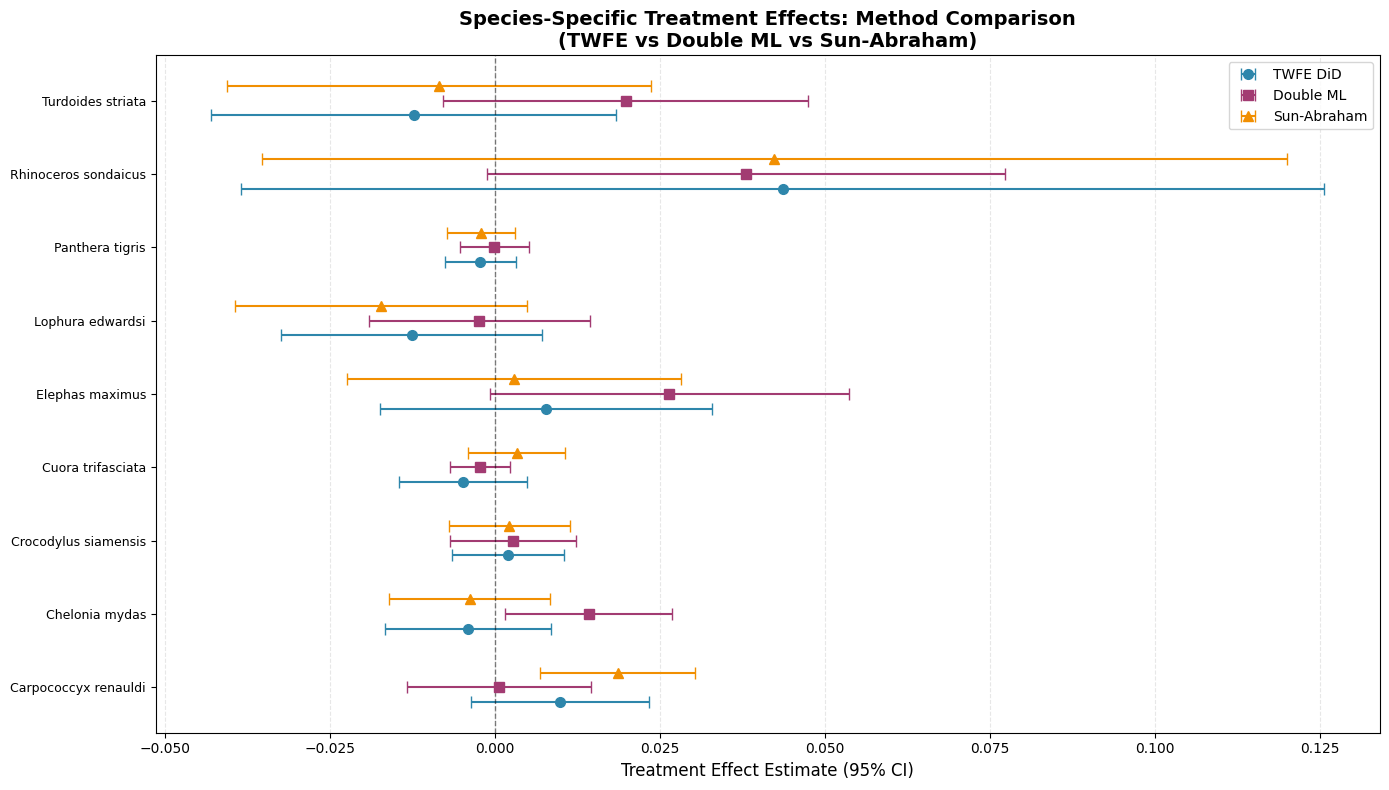

In [55]:
# Step 7.12: Species-Level Forest Plot (All Three Methods)

if species_sa_results and 'species_comparison' in dir():
    # Filter to species with all three methods
    complete_species = species_comparison.dropna(subset=['twfe_ate', 'dml_cate', 'sa_att'])
    
    if len(complete_species) > 0:
        fig, ax = plt.subplots(figsize=(14, max(8, len(complete_species) * 0.4)))
        
        n_species = len(complete_species)
        y_positions = np.arange(n_species) * 3  # Space out by 3 units per species
        
        colors_method = {'TWFE': '#2E86AB', 'DML': '#A23B72', 'SA': '#F18F01'}
        markers_method = {'TWFE': 'o', 'DML': 's', 'SA': '^'}
        
        for idx, (i, row) in enumerate(complete_species.iterrows()):
            y_base = y_positions[idx]
            
            # TWFE
            ax.errorbar(row['twfe_ate'], y_base - 0.6, 
                       xerr=1.96*row['twfe_se'],
                       fmt=markers_method['TWFE'], markersize=7, capsize=4,
                       color=colors_method['TWFE'], ecolor=colors_method['TWFE'],
                       label='TWFE DiD' if idx == 0 else '', linewidth=1.5)
            
            # DML
            ax.errorbar(row['dml_cate'], y_base, 
                       xerr=1.96*row['dml_se'],
                       fmt=markers_method['DML'], markersize=7, capsize=4,
                       color=colors_method['DML'], ecolor=colors_method['DML'],
                       label='Double ML' if idx == 0 else '', linewidth=1.5)
            
            # Sun-Abraham
            ax.errorbar(row['sa_att'], y_base + 0.6, 
                       xerr=1.96*row['sa_se'],
                       fmt=markers_method['SA'], markersize=7, capsize=4,
                       color=colors_method['SA'], ecolor=colors_method['SA'],
                       label='Sun-Abraham' if idx == 0 else '', linewidth=1.5)
        
        # Zero reference line
        ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Labels
        ax.set_yticks(y_positions)
        ax.set_yticklabels(complete_species['species'].values, fontsize=9)
        ax.set_xlabel('Treatment Effect Estimate (95% CI)', fontsize=12)
        ax.set_title('Species-Specific Treatment Effects: Method Comparison\n(TWFE vs Double ML vs Sun-Abraham)', 
                    fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        
        species_forest_path = sa_dir / 'species_forest_plot.png'
        plt.savefig(species_forest_path, dpi=300, bbox_inches='tight')
        print(f"✓ Species-level forest plot saved to: {species_forest_path}")
        
        plt.show()
    else:
        print("No species with complete results across all three methods.")
else:
    print("Insufficient data for species-level forest plot.")

In [56]:
# Step 7.13: Summary of Sun-Abraham Analysis

print("="*80)
print("SUN-ABRAHAM ANALYSIS COMPLETE")
print("="*80)

print("\nFiles saved to:", sa_dir)
print("\nOverall Results:")
print(f"  - overall_att.csv: Overall treatment effect estimate")
print(f"  - cohort_results.csv: Cohort-specific treatment effects")
print(f"  - cohort_att_plot.png: Visualization of cohort effects")

print("\nMethod Comparison:")
print(f"  - method_comparison_three_way.csv: TWFE vs DML vs Sun-Abraham")
print(f"  - forest_plot_three_way.png: Forest plot of method comparison")

if species_sa_results:
    print("\nSpecies-Specific Results:")
    print(f"  - species_specific_sa.csv: Sun-Abraham estimates for {len(species_sa_results)} species")
    print(f"  - species_method_comparison.csv: Three-method comparison by species")
    print(f"  - species_forest_plot.png: Species-level forest plot")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)

if sa_results:
    print(f"\n1. Overall Treatment Effect (Sun-Abraham):")
    print(f"   ATT = {sa_results['overall_att']:.4f} (SE: {sa_results['overall_se']:.4f})")
    ci_l = sa_results['overall_att'] - 1.96 * sa_results['overall_se']
    ci_u = sa_results['overall_att'] + 1.96 * sa_results['overall_se']
    print(f"   95% CI: [{ci_l:.4f}, {ci_u:.4f}]")
    
    pval = 2 * (1 - stats.norm.cdf(abs(sa_results['overall_att'] / sa_results['overall_se'])))
    sig = "***" if pval < 0.01 else ("**" if pval < 0.05 else ("*" if pval < 0.10 else ""))
    print(f"   P-value: {pval:.4f} {sig}")
    
    print(f"\n2. Treatment Heterogeneity:")
    print(f"   Number of cohorts: {len(sa_results['cohort_results'])}")
    cohort_coefs = [r['coef'] for r in sa_results['cohort_results'].values()]
    print(f"   Cohort ATT range: [{min(cohort_coefs):.4f}, {max(cohort_coefs):.4f}]")
    
    if 'comparison_three' in dir():
        print(f"\n3. Method Comparison:")
        for _, row in comparison_three.iterrows():
            print(f"   {row['Method']:15s}: {row['ATE/ATT']:+.4f} (SE: {row['Std Error']:.4f}) {row['Significant']}")

if species_sa_results:
    print(f"\n4. Species Heterogeneity:")
    n_sig_neg = sum(1 for r in species_sa_results.values() if r['pvalue'] < 0.05 and r['overall_att'] < 0)
    n_sig_pos = sum(1 for r in species_sa_results.values() if r['pvalue'] < 0.05 and r['overall_att'] > 0)
    print(f"   Significant negative effects: {n_sig_neg}/{len(species_sa_results)}")
    print(f"   Significant positive effects: {n_sig_pos}/{len(species_sa_results)}")

print("\n" + "="*80)

SUN-ABRAHAM ANALYSIS COMPLETE

Files saved to: results\sun_abraham

Overall Results:
  - overall_att.csv: Overall treatment effect estimate
  - cohort_results.csv: Cohort-specific treatment effects
  - cohort_att_plot.png: Visualization of cohort effects

Method Comparison:
  - method_comparison_three_way.csv: TWFE vs DML vs Sun-Abraham
  - forest_plot_three_way.png: Forest plot of method comparison

Species-Specific Results:
  - species_specific_sa.csv: Sun-Abraham estimates for 9 species
  - species_method_comparison.csv: Three-method comparison by species
  - species_forest_plot.png: Species-level forest plot

KEY FINDINGS:

1. Overall Treatment Effect (Sun-Abraham):
   ATT = -0.0079 (SE: 0.0035)
   95% CI: [-0.0148, -0.0010]
   P-value: 0.0246 **

2. Treatment Heterogeneity:
   Number of cohorts: 20
   Cohort ATT range: [-0.0398, 0.0429]

3. Method Comparison:
   TWFE DiD       : -0.0081 (SE: 0.0036) **
   Double ML      : +0.0126 (SE: 0.0034) ***
   Sun-Abraham    : -0.0079 (SE: 0

In [37]:
# Step 8: Treatment Map Visualization
print("\n" + "="*80)
print("STEP 8: Spatial Visualization of Treatment")
print("="*80)

if 'grid_gdf' in locals() and 'treatment_df' in locals():
    # Pick a year with notable treatment
    treatment_by_year = treatment_df.groupby('year').size()
    peak_year = treatment_by_year.idxmax()
    
    print(f"Visualizing treatment for year {peak_year} (peak treatment year)")
    print(f"Number of treated cells in {peak_year}: {treatment_by_year[peak_year]}")
    
    plot_treatment_map(
        grid_gdf,
        treatment_df,
        year=peak_year,
        save_path=CONFIG['results_dir'] / f'treatment_map_{peak_year}.png'
    )
    print(f"Treatment map saved to {CONFIG['results_dir'] / f'treatment_map_{peak_year}.png'}")
else:
    print("ERROR: Grid or treatment data not found")


STEP 8: Spatial Visualization of Treatment
Visualizing treatment for year 2006 (peak treatment year)
Number of treated cells in 2006: 247


AttributeError: 'NoneType' object has no attribute 'merge'

## Results Summary

The analysis pipeline has completed. Review the outputs above for:

1. **Overall Treatment Effect**: DiD estimate of disaster impact on species occupancy
2. **Event Study**: Dynamic treatment effects over time (pre/post disaster)
3. **Species Heterogeneity**: Individual species responses to disasters
4. **Spatial Patterns**: Geographic distribution of treatment

### Next Steps:

- Review the event study plot for parallel trends assumption
- Examine species-specific results for heterogeneous effects
- Run robustness checks (cells in section 12-13)
- Consider alternative specifications or subgroup analyses

## Advanced Estimators

For more advanced causal inference methods, consider:

### Synthetic Control Method
For case studies with strong single treated unit (e.g., major disaster in specific region):

```python
# Placeholder for Synthetic Control
# Use synthdid or R's Synth package via rpy2
```

### Sun-Abraham (2021) Estimator
For heterogeneous treatment effects with staggered adoption:

```python
# Use pydid or R's did package
```

### Bayesian Hierarchical Model
For pooling across species with varying effects:

```python
import pymc as pm

# Model structure:
# outcome_{i,s,t} ~ Normal(mu_{i,s,t}, sigma)
# mu_{i,s,t} = alpha_s + beta_s * treatment_{i,t} + grid_effects + time_effects
# alpha_s ~ Normal(mu_alpha, sigma_alpha)  # species intercepts
# beta_s ~ Normal(mu_beta, sigma_beta)     # species treatment effects
```

## 16. References & Resources

**Key Papers:**
- Callaway & Sant'Anna (2021): Difference-in-Differences with multiple time periods. *Journal of Econometrics*.
- Sun & Abraham (2021): Estimating dynamic treatment effects. *Journal of Econometrics*.
- Abadie et al. (2010): Synthetic control methods. *JASA*.

**Data Sources:**
- **EM-DAT:** https://www.emdat.be/
- **GBIF:** https://www.gbif.org/ (API: https://www.gbif.org/developer/occurrence)
- **IUCN Red List:** https://www.iucnredlist.org/resources/spatial-data-download
- **MODIS:** https://modis.gsfc.nasa.gov/
- **Copernicus:** https://emergency.copernicus.eu/

**Analysis Guidelines:**
- Roth et al. (2023): What's Trending in Difference-in-Differences? *JBES*.
- Cunningham (2021): Causal Inference: The Mixtape. Yale Press.